*Multi-task learning in Self eXplainable Deep Neural Networks*
==============================================================

***Master's thesis - code***

*Part 2 - Models*

**Author:** *Adrian Domagała*

# Preparatory Code: Defining Models, Essential Classes, and Functions

This section contains the essential code used throughout the entire study. It includes definitions of model performance metrics, model definitions, functions used for model optimization, functions utilized in Single-Task Learning (STL) and Multi-Task Learning (MTL) approaches, and functions for visualizing the obtained results.

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

import torch 
import torch.nn as nn
from torch.nn import MSELoss, BCELoss
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

import sklearn
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import logistic

import optuna
import dataclasses
import joblib
from functools import partial
from typing import Literal, get_args, Dict

import lime
import lime.lime_tabular
import lime.lime_base

In [2]:
from importlib import reload
reload(lime)
reload(lime.lime_tabular)
reload(lime.lime_base)

<module 'lime.lime_base' from 'C:\\Users\\adria\\anaconda3\\envs\\master_env\\Lib\\site-packages\\lime\\lime_base.py'>

## Defining Configurations


In order to standardize and simplify the definition of functions, I introduced the storage of variables in the form of dataclasses.

In [3]:
@dataclasses.dataclass
class Folders:
    base: str
    mtl: str = 'MTL/'
    dataset: str = 'Datasets/'
    study: str = 'Studies/'

@dataclasses.dataclass
class Files:
    data: str
    targets: str
    study: str

@dataclasses.dataclass
class Paths:
    data: str
    targets: str
    study: str

@dataclasses.dataclass
class Training:
    batch_size: int = 64
    num_epochs: int = 50
    patience: int = 10
    early_stopping = True
    lr: float = 0.001
    optimizer = torch.optim.Adam
    epoch_log: int = 5

@dataclasses.dataclass
class Tuning():
    name_layers: str = 'num_layers'
    max_layers: int = 5
    min_layers: int = 1
    name_neurons: str = 'num_neurons'
    max_neurons: int = None
    min_neurons: int = None
    sampler = optuna.samplers.TPESampler
    num_trials: int = 25

@dataclasses.dataclass    
class Models():
    def __init__(self, base_dir):
        self.mlp_opt: str = base_dir + "mlp_opt_"
        self.reg: str = base_dir + 'reg_'
        self.stl_reg: str = base_dir + 'stl_reg_'
        self.mtl: str = base_dir + 'mtl_alpha_'
        self.temp: str = base_dir + 'temp.pt'
        self.ext: str = '.pt'

@dataclasses.dataclass
class Result():
    metrics: float
    fid: float

@dataclasses.dataclass
class Results():
    reg: Dict[int, float] = dataclasses.field(default_factory=dict) 
    stl_mlp: Dict[int, float] = dataclasses.field(default_factory=dict) 
    stl_reg: Dict[int, float] = dataclasses.field(default_factory=dict) 
    mtl: Dict[int, dict] = dataclasses.field(default_factory=dict) 
    stl_gnf: float = None 
    mtl_gnf: Dict[str, float] = dataclasses.field(default_factory=dict) 

@dataclasses.dataclass
class Features():
    values_names = None
    names = None
    categorical = None
    numerical = None
    categorical_indices = None
    numerical_indices = None
    dummy = None

@dataclasses.dataclass
class Config:
    def __init__(self, folders: Folders, files: Files, training: Training, tuning: Tuning):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.training = training
        self.tuning = tuning
        self.folders = folders
        self.files = files
        self.models = Models(self.folders.base)
        self.paths = Paths(
            data=self.folders.dataset+self.files.data,
            targets=self.folders.dataset+self.files.targets,
            study=self.folders.study+self.files.study
        )
        self.input_size = None
        self.results = Results()
        self.alphas_list = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        self.features = Features()
        self.best_parameters = None
        self.num = 5

DIRECTION = Literal['max', 'min']

## Metrics

### Global Fidelity

In [4]:
class GlobalFidelity(nn.Module):
    def __init__(self):
        super(GlobalFidelity, self).__init__()

    def forward(self, predictions, targets):
        loss = torch.mean((predictions - targets) ** 2)
        return loss

### Logarithm of the hyperbolic cosine 

In [5]:
class LogHCos(nn.Module):
    def __init__(self):
        super(LogHCos, self).__init__()

    def forward(self, predictions, targets):
        loss = torch.mean(torch.log(torch.cosh(predictions-targets)))
        return loss

### Accuracy score

In [6]:
class AccuracyScore(nn.Module):
    def __init__(self):
        super(AccuracyScore, self).__init__()

    def forward(self, predictions, targets):
        loss = (predictions == targets).count_nonzero() / predictions.shape[0]
        return loss

## Glass-box Models

### Linear Regression 

In [7]:
class LinearRegression(nn.Module):
    def __init__(self, input_size):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        x = self.linear(x)
        return x

### Logistic Regression

In [8]:
class LogisticRegression(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

## Black-box Models

The models were defined in a way that allows for their subsequent optimization with respect to parameters such as the number of hidden layers and the number of neurons in each layer.

### Multilayer Perceptron for Classification

In [9]:
class MLP_cls(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size=1):
        super(MLP_cls, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        last_size = input_size
        for hidden in hidden_sizes:
            self.hidden_layers.append(nn.Linear(last_size, hidden))
            last_size = hidden
        self.out_layer = nn.Linear(last_size, output_size)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.relu(x)
        x = self.out_layer(x)
        x = self.sigmoid(x)
        return x

    @staticmethod
    def get_hidden_sizes(best_params, config: Config):    
        hidden_sizes = [best_params[f'{config.tuning.name_neurons}{i}'] for i in range(best_params[f'{config.tuning.name_layers}'])]
        return hidden_sizes

### Multilayer Perceptron for Regression

In [10]:
class MLP_reg(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size=1):
        super(MLP_reg, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.relu = nn.ReLU()

        last_size = input_size
        for hidden in hidden_sizes:
            self.hidden_layers.append(nn.Linear(last_size, hidden))
            last_size = hidden
        self.out_layer = nn.Linear(last_size, output_size)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.relu(x)
        x = self.out_layer(x)
        return x

    @staticmethod
    def get_hidden_sizes(best_params, config: Config):    
        hidden_sizes = [best_params[f'{config.tuning.name_neurons}{i}'] for i in range(best_params[f'{config.tuning.name_layers}'])]
        return hidden_sizes

### Training and Testing Functions

In [11]:
def eval_reg(data, target, model, criterion, device, **kwargs):
    model = model.to(device)
    model.eval()
    data, target = data.to(device), target.to(device)
    with torch.no_grad():
        output = model(data)
        loss = criterion(output, target)
        return loss

The evaluation function for classification tasks includes rounding the output to ensure the values are 0 or 1. 

In [12]:
def eval_cls(data, target, model, criterion, device, **kwargs):
    model = model.to(device)
    model.eval()
    data, target = data.to(device), target.to(device)

    with torch.no_grad():
        output = model(data)
        output = (output >= 0.5).float()
        loss = criterion(output, target)
        return loss

In [13]:
def train_model(dataloader, model, optimizer, criterion, device, **kwargs):
    model = model.to(device)
    model.train()
    for data, target in dataloader:
        optimizer.zero_grad()
        data, target = data.to(device), target.view(-1, 1).to(device)
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

### Training with early stopping criterion

Function to train the model with a specific early stopping criterion. The function evaluates the model's results on the validation set to halt training at the optimal moment, achieving the best possible results and simultaneously preventing overfitting.

In [14]:
def __get_worst_value(direction):
    if direction == 'max':
        return torch.tensor(0)
    elif direction == 'min':
        return torch.tensor(np.finfo(float).max)

def __get_compare_func(direction):
    if direction == 'max':
        return float.__gt__
    elif direction == 'min':
        return float.__lt__
    

def train_eval(data_train, target_train, data_eval, target_eval, model, criterion_train, 
               criterion_eval, eval_func, direction: DIRECTION, config: Config, 
               num_epoch=None, patience=None, **kwargs):
    
    assert direction in get_args(DIRECTION), f"Direction should be one of: {get_args(DIRECTION)}, currently is {direction}"
    if num_epoch == None:
        num_epoch = config.training.num_epochs
    if patience == None:
        patience = config.training.patience

    train_dataset = TensorDataset(data_train, target_train)
    train_dataloader = DataLoader(train_dataset, batch_size=config.training.batch_size, shuffle=True)
    optimizer = config.training.optimizer(model.parameters(), lr=config.training.lr)

    best_result = __get_worst_value(direction)
    epochs_with_no_improvement = 0

    for epoch in range(num_epoch):
        train_model(
            dataloader=train_dataloader, 
            model=model, 
            optimizer=optimizer, 
            criterion=criterion_train,
            device=config.device
        )

        result = eval_func(
            data=data_eval, 
            target=target_eval, 
            model=model, 
            criterion=criterion_eval, 
            device=config.device
        )

        compare = __get_compare_func(direction)
        if compare(result.item(), best_result.item()):
            best_result = result
            torch.save(model.state_dict(), config.models.temp)
            epochs_with_no_improvement = 0
        else:
            epochs_with_no_improvement += 1
        
        if epoch % config.training.epoch_log == 0:
            print(f"Epoch: {epoch}, result ({criterion_eval._get_name()}): {result}")

        if epochs_with_no_improvement >= patience:
            print(f"Early stopping on epoch: {epoch}, best results from epoch: {epoch-patience} result ({criterion_eval._get_name()}): {best_result}")
            model.load_state_dict(torch.load(config.models.temp))
            break
        
    return best_result

### Utility Functions

Function for loading, or training and saving models.

In [15]:
def load_or_train(func, model_path, model, overwrite=False, **kwargs):
    if overwrite:
        func(model=model, **kwargs)
        torch.save(model.state_dict(), model_path)
    else:
        try:
            model.load_state_dict(torch.load(model_path))
            print(f'Model {model_path} loaded successfully')
        except:
            print(f'Model {model_path} cannot be loaded. Training has started...')
            func(model=model, **kwargs)
            torch.save(model.state_dict(), model_path)

Functions to perform the training and testing process a specified number of times (default is 5). The collected results are stored in the configuration. Specifically:

- For regression:

    - Multilayer Perceptron (MLP)
    - Linear Regression
    - Single Task Learning (MLP and Linear Regression)

- For classification:
    - MLP
    - Logistic Regression
    - Single Task Learning (MLP and Logistic Regression)

For Regression

In [16]:
def train_and_test_mlp_reg(X_train, y_train, X_eval, y_eval, X_test, y_test, config: Config, num=None):
    if num == None:
        num = config.num
    for i in range(num):
        model = MLP_reg(input_size=config.input_size, hidden_sizes=MLP_reg.get_hidden_sizes(config.best_parameters, config), output_size=1)
        load_or_train(
            func=train_eval, 
            model_path=config.models.mlp_opt + f'{str(i)}' + config.models.ext,
            model=model,
            data_train=X_train,
            target_train=y_train,
            data_eval=X_eval,
            target_eval=y_eval,
            criterion_train=LogHCos(),
            criterion_eval=MSELoss(),
            eval_func=eval_reg,
            direction='min',
            config=config
        )

        config.results.stl_mlp[i]=eval_reg(
            X_test,
            y_test,
            model,
            MSELoss(), 
            config.device
        ).item()

In [17]:
def train_and_test_lin_reg(X_train, y_train, X_eval, y_eval, X_test, y_test, config: Config, num=None):
    if num == None:
        num = config.num
    for i in range(num):
        model = LinearRegression(config.input_size)

        load_or_train(
            func=train_eval, 
            model_path=config.models.reg + f'{str(i)}' + config.models.ext,
            model=model,
            data_train=X_train,
            target_train=y_train,
            data_eval=X_eval,
            target_eval=y_eval,
            criterion_train=LogHCos(),
            criterion_eval=MSELoss(),
            eval_func=eval_reg,
            direction='min',
            config=config
        )

        config.results.reg[i] = eval_reg(
            data=X_test,
            target=y_test,
            model=model,
            criterion=MSELoss(), 
            device=config.device
        ).item()

In [18]:
def train_and_test_stl_lin_reg(X_train, X_eval, X_test, config: Config, num=None):
    if num == None:
        num = config.num
    for i in range(num):
        mlp = MLP_reg(input_size=config.input_size, hidden_sizes=MLP_reg.get_hidden_sizes(config.best_parameters, config)).to(config.device)
        mlp.load_state_dict(torch.load(config.models.mlp_opt + str(i) + config.models.ext))
        reg = LinearRegression(input_size=config.input_size).to(config.device)

        with torch.no_grad():
            y_pred_train = mlp(X_train.to(config.device))
            y_pred_eval = mlp(X_eval.to(config.device))
            y_pred_test = mlp(X_test.to(config.device))

        load_or_train(
            func=train_eval, 
            model_path=config.models.stl_reg + str(i) + config.models.ext,
            model=reg,
            data_train=X_train,
            target_train=y_pred_train,
            data_eval=X_eval,
            target_eval=y_pred_eval,
            config=config,
            criterion_train=GlobalFidelity(),
            criterion_eval=GlobalFidelity(),
            eval_func=eval_reg,
            direction='min'
        )

        config.results.stl_reg[i] = eval_reg(
            data=X_test,
            target=y_pred_test,
            model=reg,
            criterion=GlobalFidelity(), 
            device=config.device
        ).item()

For Classification

In [19]:

def train_and_test_mlp_cls(X_train, y_train, X_eval, y_eval, X_test, y_test, config: Config, num=None):
    if num == None:
        num = config.num
    for i in range(num):
        model = MLP_cls(input_size=config.input_size, hidden_sizes=MLP_cls.get_hidden_sizes(config.best_parameters, config), output_size=1)
        load_or_train(
            func=train_eval, 
            model_path=config.models.mlp_opt + f'{str(i)}' + config.models.ext,
            model=model,
            data_train=X_train,
            target_train=y_train,
            data_eval=X_eval,
            target_eval=y_eval,
            criterion_train=BCELoss(),
            criterion_eval=AccuracyScore(),
            eval_func=eval_cls,
            direction='max',
            config=config
        )

        config.results.stl_mlp[i]=eval_cls(
            X_test,
            y_test,
            model,
            AccuracyScore(), 
            config.device
        ).item()

In [20]:

def train_and_test_lin_cls(X_train, y_train, X_eval, y_eval, X_test, y_test, config: Config, num=None):
    if num == None:
        num = config.num
    for i in range(num):
        model = LogisticRegression(config.input_size)

        load_or_train(
            func=train_eval, 
            model_path=config.models.reg + f'{str(i)}' + config.models.ext,
            model=model,
            data_train=X_train,
            target_train=y_train,
            data_eval=X_eval,
            target_eval=y_eval,
            criterion_train=BCELoss(),
            criterion_eval=AccuracyScore(),
            eval_func=eval_cls,
            direction='max',
            config=config
        )

        config.results.reg[i] = eval_cls(
            data=X_test,
            target=y_test,
            model=model,
            criterion=AccuracyScore(), 
            device=config.device
        ).item()

In [21]:
def train_and_test_stl_lin_cls(X_train, X_eval, X_test, config: Config, num=None):
    if num == None:
        num = config.num
    for i in range(num):
        mlp = MLP_cls(input_size=config.input_size, hidden_sizes=MLP_cls.get_hidden_sizes(config.best_parameters, config)).to(config.device)
        mlp.load_state_dict(torch.load(config.models.mlp_opt + str(i) + config.models.ext))
        reg = LogisticRegression(input_size=config.input_size).to(config.device)

        with torch.no_grad():
            y_pred_train = (mlp(X_train.to(config.device)) >= 0.5).float()
            y_pred_eval = (mlp(X_eval.to(config.device)) >= 0.5).float()
            y_pred_test = (mlp(X_test.to(config.device)) >= 0.5).float()

        load_or_train(
            func=train_eval, 
            model_path=config.models.stl_reg + str(i) + config.models.ext,
            model=reg,
            data_train=X_train,
            target_train=y_pred_train,
            data_eval=X_eval,
            target_eval=y_pred_eval,
            config=config,
            criterion_train=GlobalFidelity(),
            criterion_eval=GlobalFidelity(),
            eval_func=eval_cls,
            direction='min'
        )

        config.results.stl_reg[i] = eval_cls(
            data=X_test,
            target=y_pred_test,
            model=reg,
            criterion=GlobalFidelity(), 
            device=config.device
        ).item()

## Multi-Task Learning approach

In multi-task learning, two tasks were specified: the first is a predictive task based on a black-box model (multilayer perceptron), and the second is an explainability task using a linear surrogate model. The soft parameter sharing approach was applied, characterized by a separate set of parameters (weights) for each task and the absence of shared layers.  Communication between tasks occurs through information flow mechanisms; in the discussed example, this is achieved via a shared loss function, which is a convex combination of the neural network's and the surrogate model's loss functions. (The dependencies between the loss functions are regularized by the $\alpha $ parameter.)

### Model definition

In [22]:
class MTL_mlp_linear(nn.Module):
    def __init__(self, mlp, linear):
        super(MTL_mlp_linear, self).__init__()
        self.mlp = mlp
        self.linear = linear

    def forward(self, x):
        mlp_output = self.mlp(x)
        linear_output = self.linear(x)
        return mlp_output, linear_output

### Training and Testing functions

To evaluate the surrogate model, the global fidelity metric was used, whereas the neural network model was assessed using either mean squared error loss or accuracy score. The former for regression tasks and the other for classifications. It is also worth mentioning that global fidelity for classification was calculated using rounded outputs (only values 0 or 1) for both the surrogate and the MLP models. (It might be worth further analysis to consider the fidelity results for probabilities returned directly by the sigmoid function in both models).

In [23]:
def eval_mtl_cls(data, targets, model, device):
    model = model.to(device)
    data, targets = data.to(device), targets.to(device)
    model.eval()
    with torch.no_grad():
        pred_mlp, pred_reg = model(data)
        pred_mlp = (pred_mlp >= 0.5).float()
        pred_reg = (pred_reg >= 0.5).float()
    accuracy = AccuracyScore()
    acc_score = accuracy(pred_mlp, targets)
    fidelity = GlobalFidelity()
    fid_score = fidelity(pred_reg, pred_mlp)
    return acc_score.item(), fid_score.item()

In [24]:
def eval_mtl_reg(data, targets, model, device):
    model = model.to(device)
    data, targets = data.to(device), targets.to(device)
    model.eval()
    with torch.no_grad():
        pred_mlp, pred_reg = model(data)
    mse = MSELoss()
    mse_score = mse(pred_mlp, targets)
    fidelity = GlobalFidelity()
    fid_score = fidelity(pred_reg, pred_mlp)
    return mse_score.item(), fid_score.item()

In [25]:
def train_mtl_model(dataloader, model, optimizer, criterion_mlp, criterion_reg, alpha, device, **kwargs):
    model = model.to(device)
    model.train()
    for data, target in dataloader:
        optimizer.zero_grad()
        data, target = data.to(device), target.view(-1, 1).to(device)
        mlp_output, reg_output = model(data)
        loss_mlp = criterion_mlp(mlp_output, target.view(-1, 1))
        loss_reg = criterion_reg(reg_output, mlp_output)
        loss = alpha * loss_mlp + (1-alpha) * loss_reg
        loss.backward()
        optimizer.step()

### Training with early stopping criterion

Compared to the STL approach, evaluating whether to apply the early stopping criterion in MTL is somewhat more complex. This complexity arises because the model evaluation function simultaneously returns two values: the result of the neural network and the result of the surrogate model. Therefore, I applied a convex combination similar to the one in training function, based on the same parameter alpha. Ipso facto I obtained a model that performs optimally on both tasks, while maintaining the proportion of importance established during training.

In [26]:
def train_mtl_early_stop_cls(data_train, target_train, data_eval, target_eval, model, alpha, config: Config, **kwargs):
    
    train_dataset = TensorDataset(data_train, target_train)
    train_dataloader = DataLoader(train_dataset, batch_size=config.training.batch_size, shuffle=True)
    optimizer = config.training.optimizer(model.parameters(), lr=config.training.lr)

    best_acc = 0
    best_fid = np.finfo(float).max
    best_result = np.finfo(float).min
    epochs_with_no_improvement = 0

    for epoch in range(config.training.num_epochs):
        train_mtl_model( 
            dataloader=train_dataloader, 
            model=model,
            optimizer=optimizer, 
            criterion_mlp=BCELoss(),
            criterion_reg=GlobalFidelity(),
            alpha=alpha,
            device=config.device
        )

        acc, fid = eval_mtl_cls(
            data=data_eval, 
            targets=target_eval, 
            model=model, 
            device=config.device
        )

        current_result = alpha * acc - (1-alpha) * fid
        if current_result > best_result:
            best_result = current_result
            torch.save(model.state_dict(), config.models.temp)
            epochs_with_no_improvement = 0
            best_acc, best_fid = acc, fid
        else:
            epochs_with_no_improvement += 1
        
        if epoch % config.training.epoch_log == 0:
            print(f"Epoch: {epoch}, acc: {acc}, fid: {fid}")

        if epochs_with_no_improvement >= config.training.patience:
            print(f"Early stopping on epoch: {epoch}, best results from epoch: {epoch-config.training.patience}")
            print(f"Accuracy: {best_acc}, Fidelity: {best_fid}")
            model.load_state_dict(torch.load(config.models.temp))
            break
        
    return best_acc, best_fid

In [27]:
def train_mtl_early_stop_reg(data_train, target_train, data_eval, target_eval, model, alpha, config: Config, **kwargs):
    
    train_dataset = TensorDataset(data_train, target_train)
    train_dataloader = DataLoader(train_dataset, batch_size=config.training.batch_size, shuffle=True)
    optimizer = config.training.optimizer(model.parameters(), lr=config.training.lr)

    best_mse = np.finfo(float).max
    best_fid = np.finfo(float).max
    best_result = np.finfo(float).max
    epochs_with_no_improvement = 0

    for epoch in range(config.training.num_epochs):
        train_mtl_model( 
            dataloader=train_dataloader, 
            model=model,
            optimizer=optimizer, 
            criterion_mlp=LogHCos(),
            criterion_reg=GlobalFidelity(),
            alpha=alpha,
            device=config.device
        )

        mse, fid = eval_mtl_reg(
            data=data_eval, 
            targets=target_eval, 
            model=model, 
            device=config.device
        )

        current_result = alpha * mse + (1-alpha) * fid
        if current_result < best_result:
            best_result = current_result
            torch.save(model.state_dict(), config.models.temp)
            epochs_with_no_improvement = 0
            best_mse, best_fid = mse, fid
        else:
            epochs_with_no_improvement += 1
        
        if epoch % config.training.epoch_log == 0:
            print(f"Epoch: {epoch}, mse: {mse}, fid: {fid}")

        if epochs_with_no_improvement >= config.training.patience:
            print(f"Early stopping on epoch: {epoch}, best results from epoch: {epoch-config.training.patience}")
            print(f"MSE: {best_mse}, Fidelity: {best_fid}")
            model.load_state_dict(torch.load(config.models.temp))
            break
        
    return best_mse, best_fid

### Utility Functions

Functions for training and testing models with various values of the parameter alpha (default values from a closed interval [0, 1] with a step of 0.1).

In [28]:
def train_test_with_alphas_cls(data_train, data_eval, data_test, 
                               target_train, target_eval, target_test, model_params, 
                               num, config: Config, alphas_list=None):
    if not alphas_list:
        alphas_list = config.alphas_list

    config.results.mtl[num] = {}

    for alpha in alphas_list:
        print(f'Model for alpha: {alpha}')
        mlp = MLP_cls(input_size=config.input_size, hidden_sizes=MLP_cls.get_hidden_sizes(model_params, config))
        reg = LogisticRegression(input_size=config.input_size)
        model = MTL_mlp_linear(mlp=mlp, linear=reg)
        path = config.models.mtl + str(alpha) + '_' + str(num) + config.models.ext

        load_or_train(
            func=train_mtl_early_stop_cls, 
            model=model,
            model_path=path,
            data_train=data_train,
            data_eval=data_eval,
            target_train=target_train,
            target_eval=target_eval,
            alpha=alpha,
            config=config
        )
        
        acc, fid = eval_mtl_cls(data_test, target_test, model, config.device)
        print(f'Result on test dataset: {path}, Accuracy: {acc}, Fidelity: {fid}')
        config.results.mtl[num][str(alpha)] = Result(acc, fid)
    return acc, fid

In [29]:
def train_test_with_alphas_reg(data_train, data_eval, data_test, 
                               target_train, target_eval, target_test, model_params, 
                               num, config: Config, alphas_list=None):
    if not alphas_list:
        alphas_list = config.alphas_list
    
    config.results.mtl[num] = {}

    for alpha in alphas_list:
        print(f'Model for alpha: {alpha}')
        mlp = MLP_reg(input_size=config.input_size, hidden_sizes=MLP_reg.get_hidden_sizes(model_params, config))
        lin = LinearRegression(input_size=config.input_size)
        model = MTL_mlp_linear(mlp=mlp, linear=lin)
        path = config.models.mtl + str(alpha) + '_' + str(num) + config.models.ext

        load_or_train(
            func=train_mtl_early_stop_reg, 
            model=model,
            model_path=path,
            data_train=data_train,
            data_eval=data_eval,
            target_train=target_train,
            target_eval=target_eval,
            alpha=alpha,
            config=config
        )
        
        mse, fid = eval_mtl_reg(data_test, target_test, model, config.device)
        print(f'Model: {path}, MSE: {mse}, Fidelity: {fid}')
        config.results.mtl[num][str(alpha)] = Result(mse, fid)
    return mse, fid

Functions to perform the training and testing process a specified number of times (default is 5). The collected results are stored in the configuration.

In [30]:
def train_and_test_mtl_reg(X_train, y_train, X_eval, y_eval, X_test, y_test, config: Config, num=None):
    if num == None:
        num = config.num
    for i in range(num):
        train_test_with_alphas_reg(
            data_train=X_train,
            data_eval=X_eval,
            data_test=X_test,
            target_train=y_train,
            target_eval=y_eval,
            target_test=y_test,
            model_params=config.best_parameters,
            config=config,
            num=i
        )


def train_and_test_mtl_cls(X_train, y_train, X_eval, y_eval, X_test, y_test, config: Config, num=None):
    if num == None:
        num = config.num
    for i in range(num):
        train_test_with_alphas_cls(
            data_train=X_train,
            data_eval=X_eval,
            data_test=X_test,
            target_train=y_train,
            target_eval=y_eval,
            target_test=y_test,
            model_params=config.best_parameters,
            config=config,
            num=i
        )

## Optimization 

The optimization is conducted using the Optuna library. Parameters that were optimized:
- number of hidden layers (ranging from 1 to 5),
- number of neurons per layer (ranging from one-quater to four times the number of input features).

Other parameters such as optimizer or learning rate were taken from the discussed reasearch. 

### Loading function 

Other optimization functions are defined individually for each dataset.

In [31]:
def try_load_study(func, config: Config, overwrite = False):
    if overwrite:
        return func(config)
    try:
        study = joblib.load(config.paths.study)
    except:
        study = func(config)
    return study

## Plotting functions

Function presenting six plots illustrating the following relationships:

- The relationship between the black-box model evaluation metric and the alpha parameter value.
- The relationship between the surrogate model evaluation metric (global fidelity), and the alpha parameter value.
- The comparison of results for the STL (Single-Task Learning) and MTL (Multi-Task Learning) approaches.

In [32]:
def draw_plots_MTL_vs_STL(metrics_label, metrics_title, config: Config):
    COLORS = ['lightcoral', 'red', 'peru', 'moccasin', 'gold', 'greenyellow', 'lime', 'turquoise', 'skyblue', 'royalblue', 'violet', 'black']
    fig, axes = plt.subplots(3, 2, figsize=(12, 18))

    metrics_score_list = []
    fid_score_list = []

    for alpha in config.alphas_list:
        temp_metric = []
        temp_fid = []
        for i in range(config.num):
            temp_metric.append(config.results.mtl[i][str(alpha)].metrics)
            temp_fid.append(config.results.mtl[i][str(alpha)].fid)
        metrics_score_list.append(np.mean(temp_metric))
        fid_score_list.append(np.mean(temp_fid))

    # metrics_score_list = [m[1].metrics for m in config.results.mtl.items()]
    # fid_score_list = [m[1].fid for m in config.results.mtl.items()]
    alphas_list = config.alphas_list
    stl_metrics_score = np.mean(list(config.results.stl_mlp.values()))
    stl_fid_score = np.mean(list(config.results.stl_reg.values()))

    print(type(stl_fid_score))

    # MSE/alpha
    axes[0, 0].plot(metrics_score_list, alphas_list, marker='o')
    axes[0, 0].set_ylabel('alpha')
    axes[0, 0].set_yticks(ticks=alphas_list)
    axes[0, 0].set_xlabel(metrics_label)
    axes[0, 0].set_title(label=f'{metrics_label}/alpha[0, 1]')

    axes[0,1].plot(metrics_score_list[1:-1], alphas_list[1:-1], marker='o')
    axes[0,1].set_ylabel('alpha')
    axes[0,1].set_yticks(ticks=alphas_list[1:-1])
    axes[0,1].set_xlabel(metrics_label)
    axes[0,1].set_title(label=f'{metrics_label}/alpha(0, 1)')

    # Fidelity/alpha
    axes[1,0].plot(fid_score_list, alphas_list, marker='o')
    axes[1,0].set_ylabel('alpha')
    axes[1,0].set_yticks(ticks=alphas_list)
    axes[1,0].set_xlabel('fidelity')
    axes[1,0].set_title(label='Fidelity/alpha[0, 1]')

    axes[1,1].plot(fid_score_list[1:-1], alphas_list[1:-1], marker='o')
    axes[1,1].set_ylabel('alpha')
    axes[1,1].set_yticks(ticks=alphas_list[1:-1])
    axes[1,1].set_xlabel('fidelity')
    axes[1,1].set_title(label='Fidelity/alpha(0, 1)')

    # MSE/Fidelity alpha [0, 1]
    metrics_score_list_ex = metrics_score_list + [stl_metrics_score]
    fid_score_list_ex = fid_score_list + [stl_fid_score]
    alphas = [f'{chr(945)}={alpha}' for alpha in alphas_list]+['STL']
    alpha_legend = alphas
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=15) for color in COLORS]

    axes[2,0].scatter(metrics_score_list_ex, fid_score_list_ex, marker='o', s=100, edgecolors='black', c=COLORS)
    axes[2,0].set_title(f'{metrics_title}/Fidelity (with STL)')
    axes[2,0].legend(legend_handles, alpha_legend + ['STL'])
    axes[2,0].set_ylabel('fidelity')
    axes[2,0].set_xlabel(metrics_label)

    # MSE/Fidelity alpha (0, 1)
    metrics_score_list_ex = metrics_score_list[1:-1] + [stl_metrics_score]
    fid_score_list_ex = [float(fid) for fid in fid_score_list[1:-1] + [stl_fid_score]]
    alphas = [f'{chr(945)}={alpha}' for alpha in alphas_list[1:-1]]+['STL    ']
    colors = COLORS[1:-2] + ['black']
    plot_data = [[alpha, metrics, fid, col] for alpha, metrics, fid, col in sorted(zip(alphas, metrics_score_list_ex, fid_score_list_ex, colors), key=lambda l: l[2], reverse=reversed)]

    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=15) for color in [pd[3] for pd in plot_data]]
    legend = [f"{alpha} ({'{:.4f}'.format(round(float(metrics), 4))} / {'{:.4f}'.format(round(fid, 4))})" for alpha, metrics, fid, _ in plot_data]

    axes[2,1].scatter(metrics_score_list_ex, fid_score_list_ex, marker='o', s=100, edgecolors='black', c=colors)
    axes[2,1].set_title(f'{metrics_title}/Fidelity (with STL)')
    axes[2,1].legend(handles=legend_handles, labels=legend, title=f'alphas ({metrics_label}/fid)', loc='center left', bbox_to_anchor=(1, 0.5))
    axes[2,1].set_ylabel('fidelity')
    axes[2,1].set_xlabel(metrics_label)

    plt.tight_layout()
    plt.show()

In [33]:
def show_tables(metrics_label, config: Config):

    df1 = pd.read_pickle(config.folders.base + 'results_lin_vs_non_lin.pkl')

    df1 = pd.DataFrame({
        'Metric': [metrics_label],
        'Dataset': [config.folders.base.split('/')[0]],
        'Linear': [np.mean(list(config.results.reg.values()))],
        'Non-linear (MLP)': [np.mean(list(config.results.stl_mlp.values()))]
    })
    df1.to_pickle(config.folders.base + 'results_lin_vs_non_lin.pkl')

    display(df1.style.format(precision=4, decimal=",").hide())


    df2 = pd.read_pickle(config.folders.base + 'results_stl_vs_mtl.pkl')

    df2 = pd.DataFrame({
        'Metric': [metrics_label, 'Global Fidelity'],
        'Dataset': [config.folders.base.split('/')[0], config.folders.base.split('/')[0]],
        'Linear': [np.mean(list(config.results.reg.values())), '-'],
        'STL': [np.mean(list(config.results.stl_mlp.values())), np.mean(list(config.results.stl_reg.values()))]
    })

    for alpha in config.alphas_list:
        temp_metric = []
        temp_fid = []
        for i in range(config.num):
            temp_metric.append(config.results.mtl[i][str(alpha)].metrics)
            temp_fid.append(config.results.mtl[i][str(alpha)].fid)
        df2[f'MTL a= {str(alpha)}'] = [np.mean(temp_metric), np.mean(temp_fid)]
        # df2[f'MTL a= {str(alpha)}'] = [config.results.mtl[str(alpha)].metrics, config.results.mtl[str(alpha)].fid]

        df2.to_pickle(config.folders.base + 'results_stl_vs_mtl.pkl')

    display(df2.style.format(precision=4, decimal=",").hide())


## Local Explainability with Lime

### Prediction Functions

Definitions of the prediction functions for classification - LIME requires a minimum of two classes; therefore, the prediction function should return two probability values. Also prediction function should include appropriate data transformations, as the models were trained on encoded data.

In [34]:
def predict_cls_for_lime(X, model, config: Config):
    model.eval()
    X = pd.DataFrame(X, columns=config.features.names)
    X = pd.get_dummies(X, columns=config.features.categorical, dtype=float)
    X = X.reindex(columns=config.features.dummy, fill_value=0.0).values
    X = torch.tensor(X, dtype=torch.float32).to(config.device)
    
    with torch.no_grad():
        pred = model(X).cpu().numpy()
        
    return np.hstack((1 - pred, pred))

In [35]:
def predict_mtl_cls_for_lime(X, model, config: Config):
    model.eval()
    X = pd.DataFrame(X, columns=config.features.names)
    X = pd.get_dummies(X, columns=config.features.categorical, dtype=float)
    X = X.reindex(columns=config.features.dummy, fill_value=0.0).values
    X = torch.tensor(X, dtype=torch.float32).to(config.device)
    
    with torch.no_grad():
        pred = model(X)[0].cpu().numpy()

    return np.hstack((1 - pred, pred))

Definitions of the prediction functions for regression 

In [36]:
def predict_reg_for_lime(X, model, config: Config):
    model.eval()
    X = pd.DataFrame(X, columns=config.features.names)
    X = pd.get_dummies(X, columns=config.features.categorical, dtype=float)
    X = X.reindex(columns=config.features.dummy, fill_value=0.0).values
    X = torch.tensor(X, dtype=torch.float32).to(config.device)
    
    with torch.no_grad():
        pred = model(X).cpu().numpy()
        
    return pred

In [37]:
def predict_mtl_reg_for_lime(X, model, config: Config):
    model.eval()
    X = pd.DataFrame(X, columns=config.features.names)
    X = pd.get_dummies(X, columns=config.features.categorical, dtype=float)
    X = X.reindex(columns=config.features.dummy, fill_value=0.0).values
    X = torch.tensor(X, dtype=torch.float32).to(config.device)
    
    with torch.no_grad():
        pred = model(X)[0].cpu().numpy()
        
    return pred

### Utility Functions 

Function for generating neighbors ($|N_x| = 10$)
- For continuous features: using a normal distribution $\mathcal{N}(𝑥,𝜇,𝜎^2)$
where $µ=0, σ^2=0.1$
- For categorical features: lack of information in the discussed study 

TODO 

In [38]:
std_deviation = np.sqrt(0.1)
def generate_neighbors_continuous_only(instance, config: Config, mean=0, std_deviation=std_deviation, num_neighbors=10, features_num_idx=None):
    if features_num_idx==None:
        features_num_idx = config.features.numerical_indices
    perturbations = np.random.normal(loc=0, scale=std_deviation, size=(num_neighbors, len(features_num_idx)))
    neighbors = np.repeat(instance.reshape(1, -1), num_neighbors, axis=0)
    neighbors[:, features_num_idx] += perturbations
    return neighbors

In [39]:
# def get_random_cat_value(column_num, config: Config, number=10):
#     return np.array([random.randint(0, config.features.values_names[column_num].shape[0]-1) for _ in range(number)])

# def generate_neighbors(instance, config: Config, mean=0, std_deviation=std_deviation, num_neighbors=10, features_cat_idx=None, features_num_idx=None):
#     if features_cat_idx==None:
#         features_cat_idx = config.features.categorical_indices
#     if features_num_idx==None:
#         features_num_idx = config.features.numerical_indices
#     perturbations = np.random.normal(loc=0, scale=std_deviation, size=(num_neighbors, len(features_num_idx)))
#     neighbors = np.repeat(instance.reshape(1, -1), num_neighbors, axis=0)
#     neighbors[:, features_num_idx] += perturbations
#     for feature in features_cat_idx:
#         neighbors[:, feature] = get_random_cat_value(feature, config, num_neighbors)
#     return neighbors

In [40]:
# (LIME rounds data to two decimal places; therefore, I have done the same.)
# def get_lime_prediction(instance, exp, config: Config):
#     prediction = exp.intercept[1]
#     i = 0 
#     for rule, weight in exp.as_list():
#         i += 1
#         if ' < ' in rule and ' <= ' in rule:
#             value1, rest = rule.split(' < ')
#             feature, value2 = rest.split(' <= ')
#             if float(value1) < round(instance[config.features.names.index(feature)], 2) <= float(value2):
#                 prediction += weight    
#         elif ' <= ' in rule:
#             feature, value = rule.split(' <= ')
#             if round(instance[config.features.names.index(feature)], 2) <= float(value):
#                 prediction += weight
#         elif ' > ' in rule:
#             feature, value = rule.split(' > ')
#             if round(instance[config.features.names.index(feature)], 2) > float(value):
#                 prediction += weight
#         elif '=' in rule:
#             feature, value = rule.split('=')
#             feature_idx = config.features.names.index(feature)
#             if config.features.values_names[feature_idx][int(instance[feature_idx])] == value:
#                 prediction += weight
#     return prediction

In [41]:
def get_lime_prediction(instance, exp):
    pred = sum([x[1]*instance[x[0]] for x in exp.local_exp[1]]) + exp.intercept[1]
    return pred

In [42]:
def show_tables_lime(metrics_label, config: Config, num=0):

    df3 = pd.DataFrame({
        'Metric': [metrics_label, 'Global Neighborhood Fidelity'],
        'Dataset': [config.folders.base.split('/')[0], config.folders.base.split('/')[0]],
        'Linear': [config.results.reg[num], '-'],
        'STL': [config.results.stl_mlp[num], config.results.stl_gnf.item()]
    })

    for alpha in config.alphas_list:
        df3[f'MTL a= {str(alpha)}'] = [config.results.mtl[num][str(alpha)].metrics, config.results.mtl_gnf[str(alpha)].item()]
        
    df3.to_pickle(config.folders.base + 'results_gnf.pkl')

    display(df3.style.format(precision=3, decimal=",").hide())

### Global Neighborhood Fidelity

Global Neighborhood Fidelity is defined as the averaged value of Neighborhood Fidelity for all data points. Neighborhood Fidelity, in turn, is defined as the value of Global Fidelity in the local neighborhood of a given point.

Global Neighborhood Fidelity for regression

In [43]:
def global_neighborhood_fidelity_reg(model, neighbors_dataset, explainer, predict_func_lime, predict_func_model, config: Config, num_neighbors=10):
    fidelity = GlobalFidelity()
    fidelity_score = []
    for instance in neighbors_dataset:
        exp = explainer.explain_instance(instance, predict_func_lime)

        instance_sim = instance.copy()
        instance_sim[config.features.categorical_indices] = 1
        local_neighbors = generate_neighbors_continuous_only(instance_sim, config, num_neighbors)

        lime_predictions = torch.tensor([get_lime_prediction(x, exp) for x in local_neighbors])
        model_predictions = torch.tensor(np.array([pred for pred in predict_func_model(local_neighbors, model, config)]))
        fidelity_score.append(fidelity(lime_predictions, model_predictions))
    return torch.mean(torch.tensor(fidelity_score))

Global Neighborhood Fidelity for classification

In [44]:
def global_neighborhood_fidelity_cls(model, neighbors_dataset, explainer, predict_func_lime, predict_func_model, config: Config, num_neighbors=10):
    fidelity = GlobalFidelity()
    fidelity_score = []
    for instance in neighbors_dataset:
        exp = explainer.explain_instance(instance, predict_func_lime)

        instance_sim = instance.copy()
        instance_sim[config.features.categorical_indices] = 1
        local_neighbors = generate_neighbors_continuous_only(instance_sim, config, num_neighbors)
        
        lime_predictions = (torch.tensor([get_lime_prediction(x, exp) for x in local_neighbors]) >= 0.5).float()
        model_predictions = (torch.tensor(np.array([pred2 for pred1, pred2 in predict_func_model(local_neighbors, model, config)])) >= 0.5).float()
        fidelity_score.append(fidelity(lime_predictions, model_predictions))
    return torch.mean(torch.tensor(fidelity_score))

Global Neighborhood Fidelity for MTL regression

In [45]:
def global_neighborhood_fidelity_mtl_reg(neighbors_dataset, explainer, model_params, config: Config, num_neighbors=10, alphas_list=None):
    if not alphas_list:
        alphas_list = config.alphas_list
    for alpha in alphas_list:
        print(f'Model for alpha: {alpha}')
        mlp = MLP_reg(input_size=config.input_size, hidden_sizes=MLP_reg.get_hidden_sizes(model_params, config))
        lin = LinearRegression(input_size=config.input_size)
        model = MTL_mlp_linear(mlp=mlp, linear=lin).to(config.device)
        path = config.models.mtl + str(alpha) + '_0' + config.models.ext

        predict_func_lime = partial(predict_mtl_reg_for_lime, model=model, config=config)

        model.load_state_dict(torch.load(path))
        config.results.mtl_gnf[str(alpha)] = global_neighborhood_fidelity_reg(
            model=model,
            neighbors_dataset=neighbors_dataset,
            explainer=explainer, 
            predict_func_lime=predict_func_lime,
            predict_func_model=predict_mtl_reg_for_lime,
            config=config, 
            num_neighbors=num_neighbors
        )
        print(f'Model: {path}, GNF: {config.results.mtl_gnf[str(alpha)]}')

Global Neighborhood Fidelity for MTL classification

In [46]:
def global_neighborhood_fidelity_mtl_cls(neighbors_dataset, explainer, model_params, config: Config, num_neighbors=10, alphas_list=None):
    if not alphas_list:
        alphas_list = config.alphas_list
    for alpha in alphas_list:
        print(f'Model for alpha: {alpha}')
        mlp = MLP_cls(input_size=config.input_size, hidden_sizes=MLP_cls.get_hidden_sizes(model_params, config))
        lin = LogisticRegression(input_size=config.input_size)
        model = MTL_mlp_linear(mlp=mlp, linear=lin).to(config.device)
        path = config.models.mtl + str(alpha) + '_0' + config.models.ext

        predict_func_lime = partial(predict_mtl_cls_for_lime, model=model, config=config)

        model.load_state_dict(torch.load(path))
        config.results.mtl_gnf[str(alpha)] = global_neighborhood_fidelity_cls(
            model=model,
            neighbors_dataset=neighbors_dataset,
            explainer=explainer, 
            predict_func_lime=predict_func_lime,
            predict_func_model=predict_mtl_cls_for_lime,
            config=config, 
            num_neighbors=num_neighbors
        )
        print(f'Model: {path}, GNF: {config.results.mtl_gnf[str(alpha)]}')

# Training and Testing Models

For each dataset, I will follow the workflow outlined below:
1. Preparation:

    - Creating object of Config class to store all configurations.
    - Loading and standardize data:
    
        Since the Lime library will be utilized in the subsequent sections of this study, some actions at the initial stage are directly dictated by the need for later compatibility with Lime (these steps were directly taken from the official Lime tutorials at *https://github.com/marcotcr/lime*. 
        
        For example, the Lime explainer requires numerical data, even if the features are categorical. Therefore, I transform the data using Sklearn's LabelEncoder. Simultaneously, to prevent the learning model from confusing continuous features with numerically represented categorical features, the data should be encoded using techniques such as One-hot Encoder. The encoded data will be used exclusively in the learning model; the Explainer cannot use such data to ensure that each feature is used at most once in the explanation.
        
        This leads to the creation of separate datasets with different transformations applied, and at the same time, conversion between them must be possible. I have also created a dictionary to store references between categorical feature values and their names.

2. Finding the best multilayer perceptron parameters

    - Create Optuna study to find best parameters such as number of hidden layers and number of neuron per layer.

3. Training and Testing MLP 

    - For training, the Adam optimizer with a learning rate $η = 10^{−3}$ was used, along with the ReLU activation function for the hidden layers. As loss function binary cross-entropy was employed for classification tasks and the logarithm of the hyperbolic cosine for regression tasks. Whereas for evaluation, the Accuracy and Mean Squared Error metrics were used. The network structure itself was obtained through optimization.

4. Training and Testing Linear Model

    - Training and testing Linear Regression for regression tasks or Logistic Regression for classification tasks to compare its results with the MLP.
    
5. Training and Testing STL Surogate Model

6. Training and Testing Models in MTL Approach 

7. Comparison of STL with MTL

8. Local Explainability Evaluation

    


## Auto MPG

### Preparation

#### Configuration Settings

In [47]:
auto_cfg = Config(
    folders=Folders(base="Auto/"),
    files=Files(
        data="auto_data.pkl", 
        targets="auto_targets.pkl", 
        study='Auto.plt'
    ),
    training=Training(batch_size=64, num_epochs=750, patience=24),
    tuning=Tuning(num_trials = 50),
)

#### Data Loading and Standardization

In [48]:
# Data Loading
auto_df = pd.read_pickle(auto_cfg.paths.data)

auto_cfg.features.numerical = auto_df.select_dtypes(include='number').columns.values.tolist()
auto_cfg.features.numerical_indices = [auto_df.columns.get_loc(feature) for feature in auto_cfg.features.numerical]
auto_cfg.features.categorical = auto_df.select_dtypes(include='object').columns.values.tolist()
auto_cfg.features.categorical_indices = [auto_df.columns.get_loc(feature) for feature in auto_cfg.features.categorical]
auto_cfg.features.names = auto_df.columns.values.tolist()


# Creating Dictionary 
auto_cfg.features.values_names = {}
for feature, idx in zip(auto_cfg.features.categorical, auto_cfg.features.categorical_indices):
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(auto_df[feature])
    auto_df[feature] = le.transform(auto_df[feature])
    auto_cfg.features.values_names[idx] = le.classes_
    
# Data Splitting
auto_X_train, auto_X_test, auto_y_train, auto_y_test = train_test_split(
    auto_df,
    np.array(pd.read_pickle(auto_cfg.paths.targets)), 
    test_size=0.2, 
    random_state=42
)

auto_X_eval, auto_X_test, auto_y_eval, auto_y_test = train_test_split(
    auto_X_test, 
    auto_y_test, 
    test_size=0.5, 
    random_state=42
)

# Data Scaling
auto_scaler = StandardScaler()
auto_X_train[auto_cfg.features.numerical] = auto_scaler.fit_transform(auto_X_train[auto_cfg.features.numerical]).astype(float)
auto_X_train[auto_cfg.features.categorical] = auto_X_train[auto_cfg.features.categorical].astype(float)

auto_X_eval[auto_cfg.features.numerical] = auto_scaler.transform(auto_X_eval[auto_cfg.features.numerical]).astype(float)
auto_X_eval[auto_cfg.features.categorical] = auto_X_eval[auto_cfg.features.categorical].astype(float)

auto_X_test[auto_cfg.features.numerical] = auto_scaler.transform(auto_X_test[auto_cfg.features.numerical]).astype(float)
auto_X_test[auto_cfg.features.categorical] = auto_X_test[auto_cfg.features.categorical].astype(float)

auto_scaler_y = StandardScaler()
auto_y_train = auto_scaler_y.fit_transform(auto_y_train)
auto_y_eval = auto_scaler_y.transform(auto_y_eval)
auto_y_test = auto_scaler_y.transform(auto_y_test)

# Data Encoding with reindexing to maintain uniform number of columns
auto_cfg.features.dummy = pd.get_dummies(auto_df.astype(float), columns=auto_cfg.features.categorical, dtype=float).columns 

auto_X_train_encoded = pd.get_dummies(auto_X_train, columns=auto_cfg.features.categorical, dtype=float)
auto_X_train_encoded = auto_X_train_encoded.reindex(columns=auto_cfg.features.dummy, fill_value=0.0).values

auto_X_eval_encoded = pd.get_dummies(auto_X_eval, columns=auto_cfg.features.categorical, dtype=float)
auto_X_eval_encoded = auto_X_eval_encoded.reindex(columns=auto_cfg.features.dummy, fill_value=0.0).values

auto_X_test_encoded = pd.get_dummies(auto_X_test, columns=auto_cfg.features.categorical, dtype=float)
auto_X_test_encoded = auto_X_test_encoded.reindex(columns=auto_cfg.features.dummy, fill_value=0.0).values

# Data Conversion 
auto_X_train_tensor = torch.tensor(auto_X_train_encoded, dtype=torch.float32)
auto_X_eval_tensor = torch.tensor(auto_X_eval_encoded, dtype=torch.float32)
auto_X_test_tensor = torch.tensor(auto_X_test_encoded, dtype=torch.float32)

auto_y_train_tensor = torch.tensor(auto_y_train, dtype=torch.float32)
auto_y_eval_tensor = torch.tensor(auto_y_eval, dtype=torch.float32)
auto_y_test_tensor = torch.tensor(auto_y_test, dtype=torch.float32)

auto_X_train_np = auto_X_train.values
auto_X_eval_np = auto_X_eval.values
auto_X_test_np = auto_X_test.values

# Updating Configuration 
auto_cfg.input_size = auto_X_train_tensor.shape[1]
auto_cfg.tuning.min_neurons = auto_cfg.input_size // 4 - 1
auto_cfg.tuning.max_neurons = auto_cfg.input_size * 4 + 1

### Finding Best MLP model

#### Optimization Function

In [49]:
def train_and_optimize_auto(trial, config: Config):
    print(f"Trial: {trial}")
    num_layers = trial.suggest_int(config.tuning.name_layers, config.tuning.min_layers, config.tuning.max_layers)
    hidden_sizes = [trial.suggest_int(f'{config.tuning.name_neurons}{i}', config.tuning.min_neurons, config.tuning.max_neurons) for i in range(num_layers)]

    model = MLP_reg(config.input_size, hidden_sizes, 1)

    mse = train_eval(
        data_train=auto_X_train_tensor,
        target_train=auto_y_train_tensor,
        data_eval=auto_X_eval_tensor,
        target_eval=auto_y_eval_tensor,
        model=model,
        criterion_train=LogHCos(),
        criterion_eval=MSELoss(),
        eval_func=eval_reg,
        direction='min',
        config=config
    )
    return mse

#### Model Optimization

In [50]:
def study_auto(config: Config):
    objective = partial(train_and_optimize_auto, config=config)
    study = optuna.create_study(
        study_name=config.files.study, 
        sampler=config.tuning.sampler(), 
        direction='minimize', 
    )
    study.optimize(objective, n_trials=config.tuning.num_trials, show_progress_bar=True)
    joblib.dump(study, config.paths.study)
    return study

auto_study = try_load_study(study_auto, auto_cfg)

In [51]:
auto_study.trials_dataframe().sort_values("value", ascending=True).head(5)

,number,value,datetime_start,datetime_complete,duration,params_num_layers,params_num_neurons0,params_num_neurons1,params_num_neurons2,params_num_neurons3,params_num_neurons4,state
20,20,0.050926,2024-06-11 03:53:03.427017,2024-06-11 03:53:09.432750,0 days 00:00:06.005733,2,25,20.0,NaN,NaN,NaN,COMPLETE
34,34,0.051560,2024-06-11 03:54:06.817615,2024-06-11 03:54:12.970148,0 days 00:00:06.152533,2,27,15.0,NaN,NaN,NaN,COMPLETE
41,41,0.053524,2024-06-11 03:54:38.429892,2024-06-11 03:54:44.162019,0 days 00:00:05.732127,3,25,17.0,21.0,NaN,NaN,COMPLETE
38,38,0.055830,2024-06-11 03:54:22.689554,2024-06-11 03:54:27.473788,0 days 00:00:04.784234,3,29,14.0,20.0,NaN,NaN,COMPLETE
44,44,0.056687,2024-06-11 03:54:51.453499,2024-06-11 03:54:54.697907,0 days 00:00:03.244408,3,22,18.0,29.0,NaN,NaN,COMPLETE


In [52]:
auto_cfg.best_parameters = auto_study.trials[20].params
auto_cfg.best_parameters

{'num_layers': 2, 'num_neurons0': 25, 'num_neurons1': 20}

### Training and Testing MLP

In [53]:
train_and_test_mlp_reg(
    X_train=auto_X_train_tensor, 
    y_train=auto_y_train_tensor,
    X_eval=auto_X_eval_tensor, 
    y_eval=auto_y_eval_tensor, 
    X_test=auto_X_test_tensor, 
    y_test=auto_y_test_tensor, 
    config=auto_cfg
)
print(np.mean(list(auto_cfg.results.stl_mlp.values())))
auto_cfg.results.stl_mlp

Model Auto/mlp_opt_0.pt loaded successfully
Model Auto/mlp_opt_1.pt loaded successfully
Model Auto/mlp_opt_2.pt loaded successfully
Model Auto/mlp_opt_3.pt loaded successfully
Model Auto/mlp_opt_4.pt loaded successfully
0.08755308240652085


{0: 0.07305106520652771,
 1: 0.07872933149337769,
 2: 0.09398653358221054,
 3: 0.09878343343734741,
 4: 0.09321504831314087}

### Training and Testing Linear Model

In [54]:
train_and_test_lin_reg(
    X_train=auto_X_train_tensor, 
    y_train=auto_y_train_tensor,
    X_eval=auto_X_eval_tensor, 
    y_eval=auto_y_eval_tensor, 
    X_test=auto_X_test_tensor, 
    y_test=auto_y_test_tensor, 
    config=auto_cfg
)
print(np.mean(list(auto_cfg.results.reg.values())))
auto_cfg.results.reg

Model Auto/reg_0.pt loaded successfully
Model Auto/reg_1.pt loaded successfully
Model Auto/reg_2.pt loaded successfully
Model Auto/reg_3.pt loaded successfully
Model Auto/reg_4.pt loaded successfully
0.16775765120983124


{0: 0.1447603702545166,
 1: 0.17536529898643494,
 2: 0.17533519864082336,
 3: 0.18911297619342804,
 4: 0.15421441197395325}

### Training and Testing STL Surogate Model

Train Logistic Regression to explain adult_mlp_stl model

In [55]:
train_and_test_stl_lin_reg(
    X_train=auto_X_train_tensor, 
    X_eval=auto_X_eval_tensor, 
    X_test=auto_X_test_tensor, 
    config=auto_cfg
)
print(np.mean(list(auto_cfg.results.stl_reg.values())))
auto_cfg.results.stl_reg

Model Auto/stl_reg_0.pt loaded successfully
Model Auto/stl_reg_1.pt loaded successfully
Model Auto/stl_reg_2.pt loaded successfully
Model Auto/stl_reg_3.pt loaded successfully
Model Auto/stl_reg_4.pt loaded successfully
0.1343540817499161


{0: 0.11500835418701172,
 1: 0.1578635722398758,
 2: 0.103199303150177,
 3: 0.11981053650379181,
 4: 0.17588864266872406}

### Training and Testing Models in MTL Approach 

MLP + LinReg, alpha in the range of 0 to 1 with a step of 0.1.

In [56]:
train_and_test_mtl_reg(
    X_train=auto_X_train_tensor,
    y_train=auto_y_train_tensor,
    X_eval=auto_X_eval_tensor, 
    y_eval=auto_y_eval_tensor, 
    X_test=auto_X_test_tensor, 
    y_test=auto_y_test_tensor, 
    config=auto_cfg
)
auto_cfg.results.mtl

Model for alpha: 0.0
Model Auto/mtl_alpha_0.0_0.pt loaded successfully
Model: Auto/mtl_alpha_0.0_0.pt, MSE: 0.26700344681739807, Fidelity: 0.00012849939230363816
Model for alpha: 0.1
Model Auto/mtl_alpha_0.1_0.pt loaded successfully
Model: Auto/mtl_alpha_0.1_0.pt, MSE: 0.14397887885570526, Fidelity: 0.00035819096956402063
Model for alpha: 0.2
Model Auto/mtl_alpha_0.2_0.pt loaded successfully
Model: Auto/mtl_alpha_0.2_0.pt, MSE: 0.13805195689201355, Fidelity: 0.001438477193005383
Model for alpha: 0.3
Model Auto/mtl_alpha_0.3_0.pt loaded successfully
Model: Auto/mtl_alpha_0.3_0.pt, MSE: 0.1432805359363556, Fidelity: 0.0035943619441241026
Model for alpha: 0.4
Model Auto/mtl_alpha_0.4_0.pt loaded successfully
Model: Auto/mtl_alpha_0.4_0.pt, MSE: 0.10951852798461914, Fidelity: 0.008837507106363773
Model for alpha: 0.5
Model Auto/mtl_alpha_0.5_0.pt loaded successfully
Model: Auto/mtl_alpha_0.5_0.pt, MSE: 0.1212691068649292, Fidelity: 0.015063555911183357
Model for alpha: 0.6
Model Auto/mtl_a

{0: {'0.0': Result(metrics=0.26700344681739807, fid=0.00012849939230363816),
  '0.1': Result(metrics=0.14397887885570526, fid=0.00035819096956402063),
  '0.2': Result(metrics=0.13805195689201355, fid=0.001438477193005383),
  '0.3': Result(metrics=0.1432805359363556, fid=0.0035943619441241026),
  '0.4': Result(metrics=0.10951852798461914, fid=0.008837507106363773),
  '0.5': Result(metrics=0.1212691068649292, fid=0.015063555911183357),
  '0.6': Result(metrics=0.10987364500761032, fid=0.024312378838658333),
  '0.7': Result(metrics=0.08603035658597946, fid=0.055600691586732864),
  '0.8': Result(metrics=0.08088409900665283, fid=0.04719290882349014),
  '0.9': Result(metrics=0.08880485594272614, fid=0.12202461808919907),
  '1.0': Result(metrics=0.11870542913675308, fid=2.0948212146759033)},
 1: {'0.0': Result(metrics=1.7358665466308594, fid=8.562408766010776e-05),
  '0.1': Result(metrics=0.18713125586509705, fid=0.0003392848011571914),
  '0.2': Result(metrics=0.16826526820659637, fid=0.001740

### Comparison of STL with MTL

In [57]:
show_tables("MSE", auto_cfg) 

Metric,Dataset,Linear,Non-linear (MLP)
MSE,Auto,"0,1678","0,0876"


Metric,Dataset,Linear,STL,MTL a= 0.0,MTL a= 0.1,MTL a= 0.2,MTL a= 0.3,MTL a= 0.4,MTL a= 0.5,MTL a= 0.6,MTL a= 0.7,MTL a= 0.8,MTL a= 0.9,MTL a= 1.0
MSE,Auto,"0,1678","0,0876","1,0361","0,1610","0,1558","0,1375","0,1194","0,1071","0,1030","0,0909","0,0850","0,0843","0,1041"
Global Fidelity,Auto,-,"0,1344","0,0002","0,0004","0,0015","0,0038","0,0084","0,0138","0,0240","0,0486","0,0628","0,1060","1,5452"


<class 'numpy.float64'>


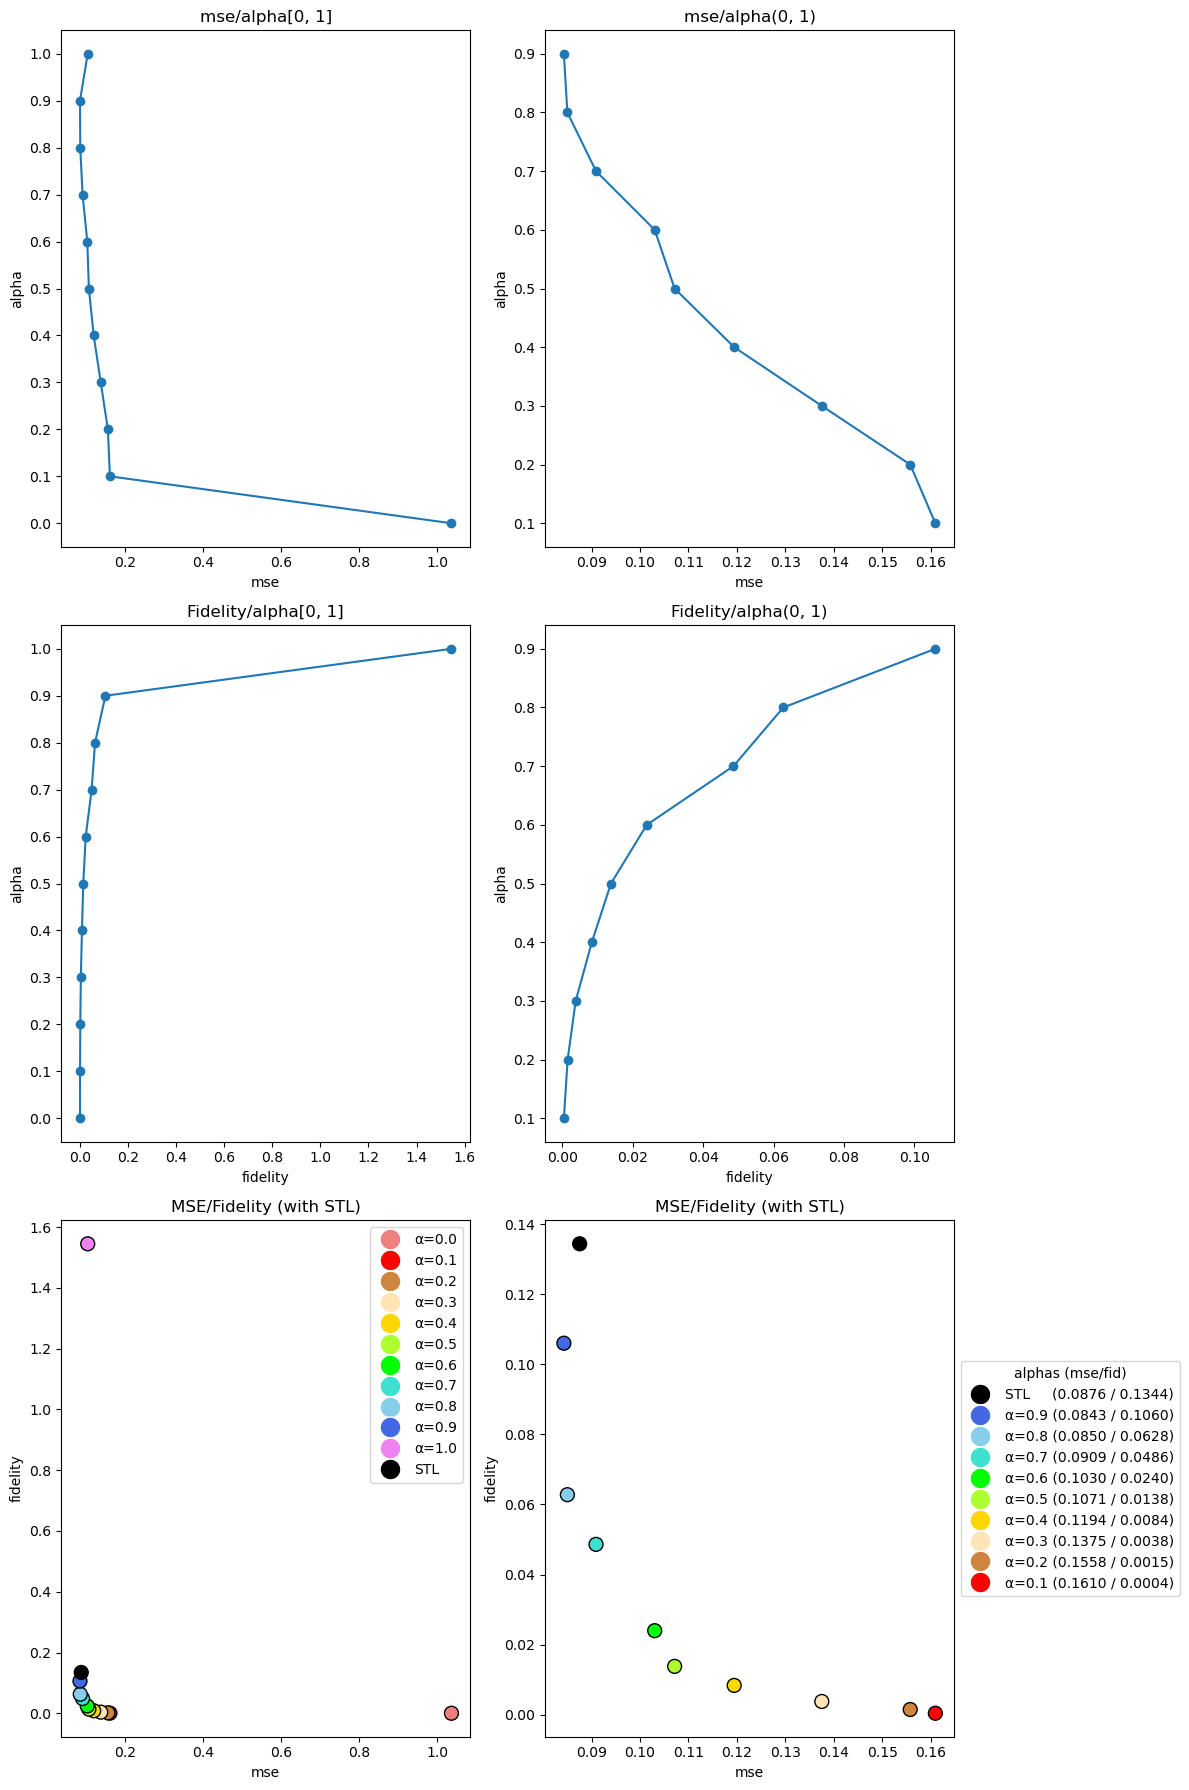

In [58]:
draw_plots_MTL_vs_STL(
    metrics_label='mse',
    metrics_title='MSE',
    config=auto_cfg
)

### Local Explainability Evaluation

Creating Explainer

In [59]:
auto_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=auto_X_train_np,
    mode='regression',
    feature_names=auto_cfg.features.names,
    verbose=False,
    class_names=['MPG'],
    categorical_features=auto_cfg.features.categorical_indices,
    categorical_names=auto_cfg.features.values_names,
    discretize_continuous = False
)
auto_explainer

Global Neighborhood Fidelity for STL MLP

In [60]:
# load model
mlp = MLP_reg(input_size=auto_cfg.input_size, hidden_sizes=MLP_reg.get_hidden_sizes(auto_cfg.best_parameters, auto_cfg)).to(auto_cfg.device)
mlp.load_state_dict(torch.load(auto_cfg.models.mlp_opt + '0' + auto_cfg.models.ext))

# prediction function
auto_predict_lime = partial(predict_reg_for_lime, model=mlp, config=auto_cfg)

# neighbors dataset
print(auto_X_test_np.shape)


auto_cfg.results.stl_gnf = global_neighborhood_fidelity_reg(
    model=mlp,
    neighbors_dataset=auto_X_test_np,
    explainer=auto_explainer,
    config=auto_cfg,
    predict_func_lime=auto_predict_lime,
    predict_func_model=predict_reg_for_lime
)
auto_cfg.results.stl_gnf

(40, 7)


tensor(0.1410, dtype=torch.float64)

Global Neighborhood Fidelity for MTL

In [61]:
global_neighborhood_fidelity_mtl_reg(
    neighbors_dataset=auto_X_test_np,
    explainer=auto_explainer,
    model_params=auto_cfg.best_parameters,
    config=auto_cfg
)
auto_cfg.results.mtl_gnf

Model for alpha: 0.0
Model: Auto/mtl_alpha_0.0_0.pt, GNF: 0.031849635117460987
Model for alpha: 0.1
Model: Auto/mtl_alpha_0.1_0.pt, GNF: 0.052937109327662844
Model for alpha: 0.2
Model: Auto/mtl_alpha_0.2_0.pt, GNF: 0.0455904535119039
Model for alpha: 0.3
Model: Auto/mtl_alpha_0.3_0.pt, GNF: 0.07685917903990644
Model for alpha: 0.4
Model: Auto/mtl_alpha_0.4_0.pt, GNF: 0.08163578783220768
Model for alpha: 0.5
Model: Auto/mtl_alpha_0.5_0.pt, GNF: 0.05928777589945859
Model for alpha: 0.6
Model: Auto/mtl_alpha_0.6_0.pt, GNF: 0.0853916401570666
Model for alpha: 0.7
Model: Auto/mtl_alpha_0.7_0.pt, GNF: 0.09673442690330794
Model for alpha: 0.8
Model: Auto/mtl_alpha_0.8_0.pt, GNF: 0.11462615641909694
Model for alpha: 0.9
Model: Auto/mtl_alpha_0.9_0.pt, GNF: 0.15460692503986537
Model for alpha: 1.0
Model: Auto/mtl_alpha_1.0_0.pt, GNF: 0.05745155305681475


{'0.0': tensor(0.0318, dtype=torch.float64),
 '0.1': tensor(0.0529, dtype=torch.float64),
 '0.2': tensor(0.0456, dtype=torch.float64),
 '0.3': tensor(0.0769, dtype=torch.float64),
 '0.4': tensor(0.0816, dtype=torch.float64),
 '0.5': tensor(0.0593, dtype=torch.float64),
 '0.6': tensor(0.0854, dtype=torch.float64),
 '0.7': tensor(0.0967, dtype=torch.float64),
 '0.8': tensor(0.1146, dtype=torch.float64),
 '0.9': tensor(0.1546, dtype=torch.float64),
 '1.0': tensor(0.0575, dtype=torch.float64)}

In [62]:
show_tables_lime("MSE", auto_cfg) 

Metric,Dataset,Linear,STL,MTL a= 0.0,MTL a= 0.1,MTL a= 0.2,MTL a= 0.3,MTL a= 0.4,MTL a= 0.5,MTL a= 0.6,MTL a= 0.7,MTL a= 0.8,MTL a= 0.9,MTL a= 1.0
MSE,Auto,"0,145","0,073","0,267","0,144","0,138","0,143","0,110","0,121","0,110","0,086","0,081","0,089","0,119"
Global Neighborhood Fidelity,Auto,-,"0,141","0,032","0,053","0,046","0,077","0,082","0,059","0,085","0,097","0,115","0,155","0,057"


## California Housing

### Preparation

#### Configuration Settings

In [63]:
housing_cfg = Config(
    folders=Folders(base="Housing/"),
    files=Files(
        data="housing_data.pkl", 
        targets="housing_targets.pkl", 
        study='Housing.plt'
    ),
    training=Training(batch_size=64, num_epochs=250, patience=12),
    tuning=Tuning(num_trials = 25),
)

#### Data Loading and Standardization

In [64]:
# Data Loading
housing_df = pd.read_pickle(housing_cfg.paths.data)

housing_cfg.features.numerical = housing_df.select_dtypes(include='number').columns.values.tolist()
housing_cfg.features.numerical_indices = [housing_df.columns.get_loc(feature) for feature in housing_cfg.features.numerical]
housing_cfg.features.categorical = housing_df.select_dtypes(include='object').columns.values.tolist()
housing_cfg.features.categorical_indices = [housing_df.columns.get_loc(feature) for feature in housing_cfg.features.categorical]
housing_cfg.features.names = housing_df.columns.values.tolist()


# Creating Dictionary 
housing_cfg.features.values_names = {}
for feature, idx in zip(housing_cfg.features.categorical, housing_cfg.features.categorical_indices):
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(housing_df[feature])
    housing_df[feature] = le.transform(housing_df[feature])
    housing_cfg.features.values_names[idx] = le.classes_
    
# Data Splitting
housing_X_train, housing_X_test, housing_y_train, housing_y_test = train_test_split(
    housing_df,
    np.array(pd.read_pickle(housing_cfg.paths.targets)), 
    test_size=0.2, 
    random_state=42
)

housing_X_eval, housing_X_test, housing_y_eval, housing_y_test = train_test_split(
    housing_X_test, 
    housing_y_test, 
    test_size=0.5, 
    random_state=42
)

# Data Scaling
housing_scaler = StandardScaler()
housing_X_train[housing_cfg.features.numerical] = housing_scaler.fit_transform(housing_X_train[housing_cfg.features.numerical]).astype(float)
housing_X_train[housing_cfg.features.categorical] = housing_X_train[housing_cfg.features.categorical].astype(float)

housing_X_eval[housing_cfg.features.numerical] = housing_scaler.transform(housing_X_eval[housing_cfg.features.numerical]).astype(float)
housing_X_eval[housing_cfg.features.categorical] = housing_X_eval[housing_cfg.features.categorical].astype(float)

housing_X_test[housing_cfg.features.numerical] = housing_scaler.transform(housing_X_test[housing_cfg.features.numerical]).astype(float)
housing_X_test[housing_cfg.features.categorical] = housing_X_test[housing_cfg.features.categorical].astype(float)

housing_scaler_y = StandardScaler()
housing_y_train = housing_scaler_y.fit_transform(housing_y_train)
housing_y_eval = housing_scaler_y.transform(housing_y_eval)
housing_y_test = housing_scaler_y.transform(housing_y_test)

# Data Encoding with reindexing to maintain uniform number of columns
housing_cfg.features.dummy = pd.get_dummies(housing_df.astype(float), columns=housing_cfg.features.categorical, dtype=float).columns 

housing_X_train_encoded = pd.get_dummies(housing_X_train, columns=housing_cfg.features.categorical, dtype=float)
housing_X_train_encoded = housing_X_train_encoded.reindex(columns=housing_cfg.features.dummy, fill_value=0.0).values

housing_X_eval_encoded = pd.get_dummies(housing_X_eval, columns=housing_cfg.features.categorical, dtype=float)
housing_X_eval_encoded = housing_X_eval_encoded.reindex(columns=housing_cfg.features.dummy, fill_value=0.0).values

housing_X_test_encoded = pd.get_dummies(housing_X_test, columns=housing_cfg.features.categorical, dtype=float)
housing_X_test_encoded = housing_X_test_encoded.reindex(columns=housing_cfg.features.dummy, fill_value=0.0).values

# Data Conversion 
housing_X_train_tensor = torch.tensor(housing_X_train_encoded, dtype=torch.float32)
housing_X_eval_tensor = torch.tensor(housing_X_eval_encoded, dtype=torch.float32)
housing_X_test_tensor = torch.tensor(housing_X_test_encoded, dtype=torch.float32)

housing_y_train_tensor = torch.tensor(housing_y_train, dtype=torch.float32)
housing_y_eval_tensor = torch.tensor(housing_y_eval, dtype=torch.float32)
housing_y_test_tensor = torch.tensor(housing_y_test, dtype=torch.float32)

housing_X_train_np = housing_X_train.values
housing_X_eval_np = housing_X_eval.values
housing_X_test_np = housing_X_test.values

# Updating Configuration 
housing_cfg.input_size = housing_X_train_tensor.shape[1]
housing_cfg.tuning.min_neurons = housing_cfg.input_size // 4 - 1
housing_cfg.tuning.max_neurons = housing_cfg.input_size * 4 + 1

### Finding Best MLP model

#### Optimization Function

In [65]:
def train_and_optimize_housing(trial, config: Config):
    print(f"Trial: {trial}")
    num_layers = trial.suggest_int(config.tuning.name_layers, config.tuning.min_layers, config.tuning.max_layers)
    hidden_sizes = [trial.suggest_int(f'{config.tuning.name_neurons}{i}', config.tuning.min_neurons, config.tuning.max_neurons) for i in range(num_layers)]

    model = MLP_reg(config.input_size, hidden_sizes, 1)

    mse = train_eval(
        data_train=housing_X_train_tensor,
        target_train=housing_y_train_tensor,
        data_eval=housing_X_eval_tensor,
        target_eval=housing_y_eval_tensor,
        model=model,
        criterion_train=LogHCos(),
        criterion_eval=MSELoss(),
        eval_func=eval_reg,
        direction='min',
        config=config
    )
    return mse

#### Model Optimization

In [66]:
def study_housing(config: Config):
    objective = partial(train_and_optimize_housing, config=config)
    study = optuna.create_study(
        study_name=config.files.study, 
        sampler=config.tuning.sampler(), 
        direction='minimize', 
    )
    study.optimize(objective, n_trials=config.tuning.num_trials, show_progress_bar=True)
    joblib.dump(study, config.paths.study)
    return study

housing_study = try_load_study(study_housing, housing_cfg)

In [67]:
housing_study.trials_dataframe().sort_values("value", ascending=True).head(5)

,number,value,datetime_start,datetime_complete,duration,params_num_layers,params_num_neurons0,params_num_neurons1,params_num_neurons2,params_num_neurons3,params_num_neurons4,state
6,6,0.205907,2024-06-11 18:42:54.180464,2024-06-11 18:43:54.142869,0 days 00:00:59.962405,5,33,7.0,28.0,1.0,21.0,COMPLETE
21,21,0.205967,2024-06-11 18:55:38.582293,2024-06-11 18:56:33.502777,0 days 00:00:54.920484,2,33,28.0,NaN,NaN,NaN,COMPLETE
22,22,0.207264,2024-06-11 18:56:33.504730,2024-06-11 18:58:01.390089,0 days 00:01:27.885359,2,33,30.0,NaN,NaN,NaN,COMPLETE
5,5,0.208787,2024-06-11 18:41:56.256738,2024-06-11 18:42:54.178511,0 days 00:00:57.921773,3,15,33.0,28.0,NaN,NaN,COMPLETE
8,8,0.209696,2024-06-11 18:45:07.352057,2024-06-11 18:46:03.255696,0 days 00:00:55.903639,2,30,27.0,NaN,NaN,NaN,COMPLETE


In [68]:
housing_cfg.best_parameters = housing_study.trials[6].params
housing_cfg.best_parameters 


{'num_layers': 5,
 'num_neurons0': 33,
 'num_neurons1': 7,
 'num_neurons2': 28,
 'num_neurons3': 1,
 'num_neurons4': 21}

### Training and Testing MLP

In [69]:
train_and_test_mlp_reg(
    X_train=housing_X_train_tensor, 
    y_train=housing_y_train_tensor,
    X_eval=housing_X_eval_tensor, 
    y_eval=housing_y_eval_tensor, 
    X_test=housing_X_test_tensor, 
    y_test=housing_y_test_tensor, 
    config=housing_cfg
)
print(np.mean(list(housing_cfg.results.stl_mlp.values())))
housing_cfg.results.stl_mlp

Model Housing/mlp_opt_0.pt loaded successfully
Model Housing/mlp_opt_1.pt loaded successfully
Model Housing/mlp_opt_2.pt loaded successfully
Model Housing/mlp_opt_3.pt loaded successfully
Model Housing/mlp_opt_4.pt loaded successfully
0.20923237204551698


{0: 0.20994256436824799,
 1: 0.21407772600650787,
 2: 0.2035071700811386,
 3: 0.20852388441562653,
 4: 0.21011051535606384}

### Training and Testing Linear Model

In [70]:
train_and_test_lin_reg(
    X_train=housing_X_train_tensor, 
    y_train=housing_y_train_tensor,
    X_eval=housing_X_eval_tensor, 
    y_eval=housing_y_eval_tensor, 
    X_test=housing_X_test_tensor, 
    y_test=housing_y_test_tensor, 
    config=housing_cfg
)
print(np.mean(list(housing_cfg.results.reg.values())))
housing_cfg.results.reg

Model Housing/reg_0.pt loaded successfully
Model Housing/reg_1.pt loaded successfully
Model Housing/reg_2.pt loaded successfully
Model Housing/reg_3.pt loaded successfully
Model Housing/reg_4.pt loaded successfully
0.36555686593055725


{0: 0.3655868172645569,
 1: 0.3649385869503021,
 2: 0.36613914370536804,
 3: 0.36488673090934753,
 4: 0.36623305082321167}

### Training and Testing STL Surogate Model

Train Linear Regression to explain housing_mlp_stl model

In [71]:
train_and_test_stl_lin_reg(
    X_train=housing_X_train_tensor, 
    X_eval=housing_X_eval_tensor, 
    X_test=housing_X_test_tensor, 
    config=housing_cfg
)
print(np.mean(list(housing_cfg.results.stl_reg.values())))
housing_cfg.results.stl_reg

Model Housing/stl_reg_0.pt loaded successfully
Model Housing/stl_reg_1.pt loaded successfully
Model Housing/stl_reg_2.pt loaded successfully
Model Housing/stl_reg_3.pt loaded successfully
Model Housing/stl_reg_4.pt loaded successfully
0.15391868054866792


{0: 0.14702565968036652,
 1: 0.1590796858072281,
 2: 0.154568150639534,
 3: 0.14747902750968933,
 4: 0.1614408791065216}

### Train and test models in MTL approach 

MLP + LogReg, alpha in range 0, 1 with step 0.1, Fidelity on rounded outputs

In [72]:
train_and_test_mtl_reg(
    X_train=housing_X_train_tensor,
    y_train=housing_y_train_tensor,
    X_eval=housing_X_eval_tensor, 
    y_eval=housing_y_eval_tensor, 
    X_test=housing_X_test_tensor, 
    y_test=housing_y_test_tensor, 
    config=housing_cfg
)
housing_cfg.results.mtl

Model for alpha: 0.0
Model Housing/mtl_alpha_0.0_0.pt loaded successfully
Model: Housing/mtl_alpha_0.0_0.pt, MSE: 1.0135225057601929, Fidelity: 4.3031900018963313e-19
Model for alpha: 0.1
Model Housing/mtl_alpha_0.1_0.pt loaded successfully
Model: Housing/mtl_alpha_0.1_0.pt, MSE: 0.3566862642765045, Fidelity: 0.0002758369082584977
Model for alpha: 0.2
Model Housing/mtl_alpha_0.2_0.pt loaded successfully
Model: Housing/mtl_alpha_0.2_0.pt, MSE: 0.3506801724433899, Fidelity: 0.0013505312381312251
Model for alpha: 0.3
Model Housing/mtl_alpha_0.3_0.pt loaded successfully
Model: Housing/mtl_alpha_0.3_0.pt, MSE: 0.32868626713752747, Fidelity: 0.0028472032863646746
Model for alpha: 0.4
Model Housing/mtl_alpha_0.4_0.pt loaded successfully
Model: Housing/mtl_alpha_0.4_0.pt, MSE: 0.3176039457321167, Fidelity: 0.006666254717856646
Model for alpha: 0.5
Model Housing/mtl_alpha_0.5_0.pt loaded successfully
Model: Housing/mtl_alpha_0.5_0.pt, MSE: 0.2905544936656952, Fidelity: 0.012637983076274395
Mode

{0: {'0.0': Result(metrics=1.0135225057601929, fid=4.3031900018963313e-19),
  '0.1': Result(metrics=0.3566862642765045, fid=0.0002758369082584977),
  '0.2': Result(metrics=0.3506801724433899, fid=0.0013505312381312251),
  '0.3': Result(metrics=0.32868626713752747, fid=0.0028472032863646746),
  '0.4': Result(metrics=0.3176039457321167, fid=0.006666254717856646),
  '0.5': Result(metrics=0.2905544936656952, fid=0.012637983076274395),
  '0.6': Result(metrics=0.26758047938346863, fid=0.02400512807071209),
  '0.7': Result(metrics=0.24328823387622833, fid=0.04077726602554321),
  '0.8': Result(metrics=0.23284293711185455, fid=0.0634886622428894),
  '0.9': Result(metrics=0.22555775940418243, fid=0.11153678596019745),
  '1.0': Result(metrics=0.21233175694942474, fid=1.1038011312484741)},
 1: {'0.0': Result(metrics=1.0140489339828491, fid=2.742841843428323e-06),
  '0.1': Result(metrics=0.3546665906906128, fid=0.000262983376160264),
  '0.2': Result(metrics=0.3411504924297333, fid=0.001338670146651

### Comparison of STL with MTL

In [73]:
show_tables("MSE", housing_cfg) 

Metric,Dataset,Linear,Non-linear (MLP)
MSE,Housing,"0,3656","0,2092"


Metric,Dataset,Linear,STL,MTL a= 0.0,MTL a= 0.1,MTL a= 0.2,MTL a= 0.3,MTL a= 0.4,MTL a= 0.5,MTL a= 0.6,MTL a= 0.7,MTL a= 0.8,MTL a= 0.9,MTL a= 1.0
MSE,Housing,"0,3656","0,2092","1,0673","0,3557","0,3444","0,3292","0,3166","0,2900","0,2718","0,2445","0,2310","0,2148","0,2082"
Global Fidelity,Housing,-,"0,1539","0,0000","0,0003","0,0013","0,0030","0,0066","0,0142","0,0223","0,0403","0,0636","0,1015","1,1493"


<class 'numpy.float64'>


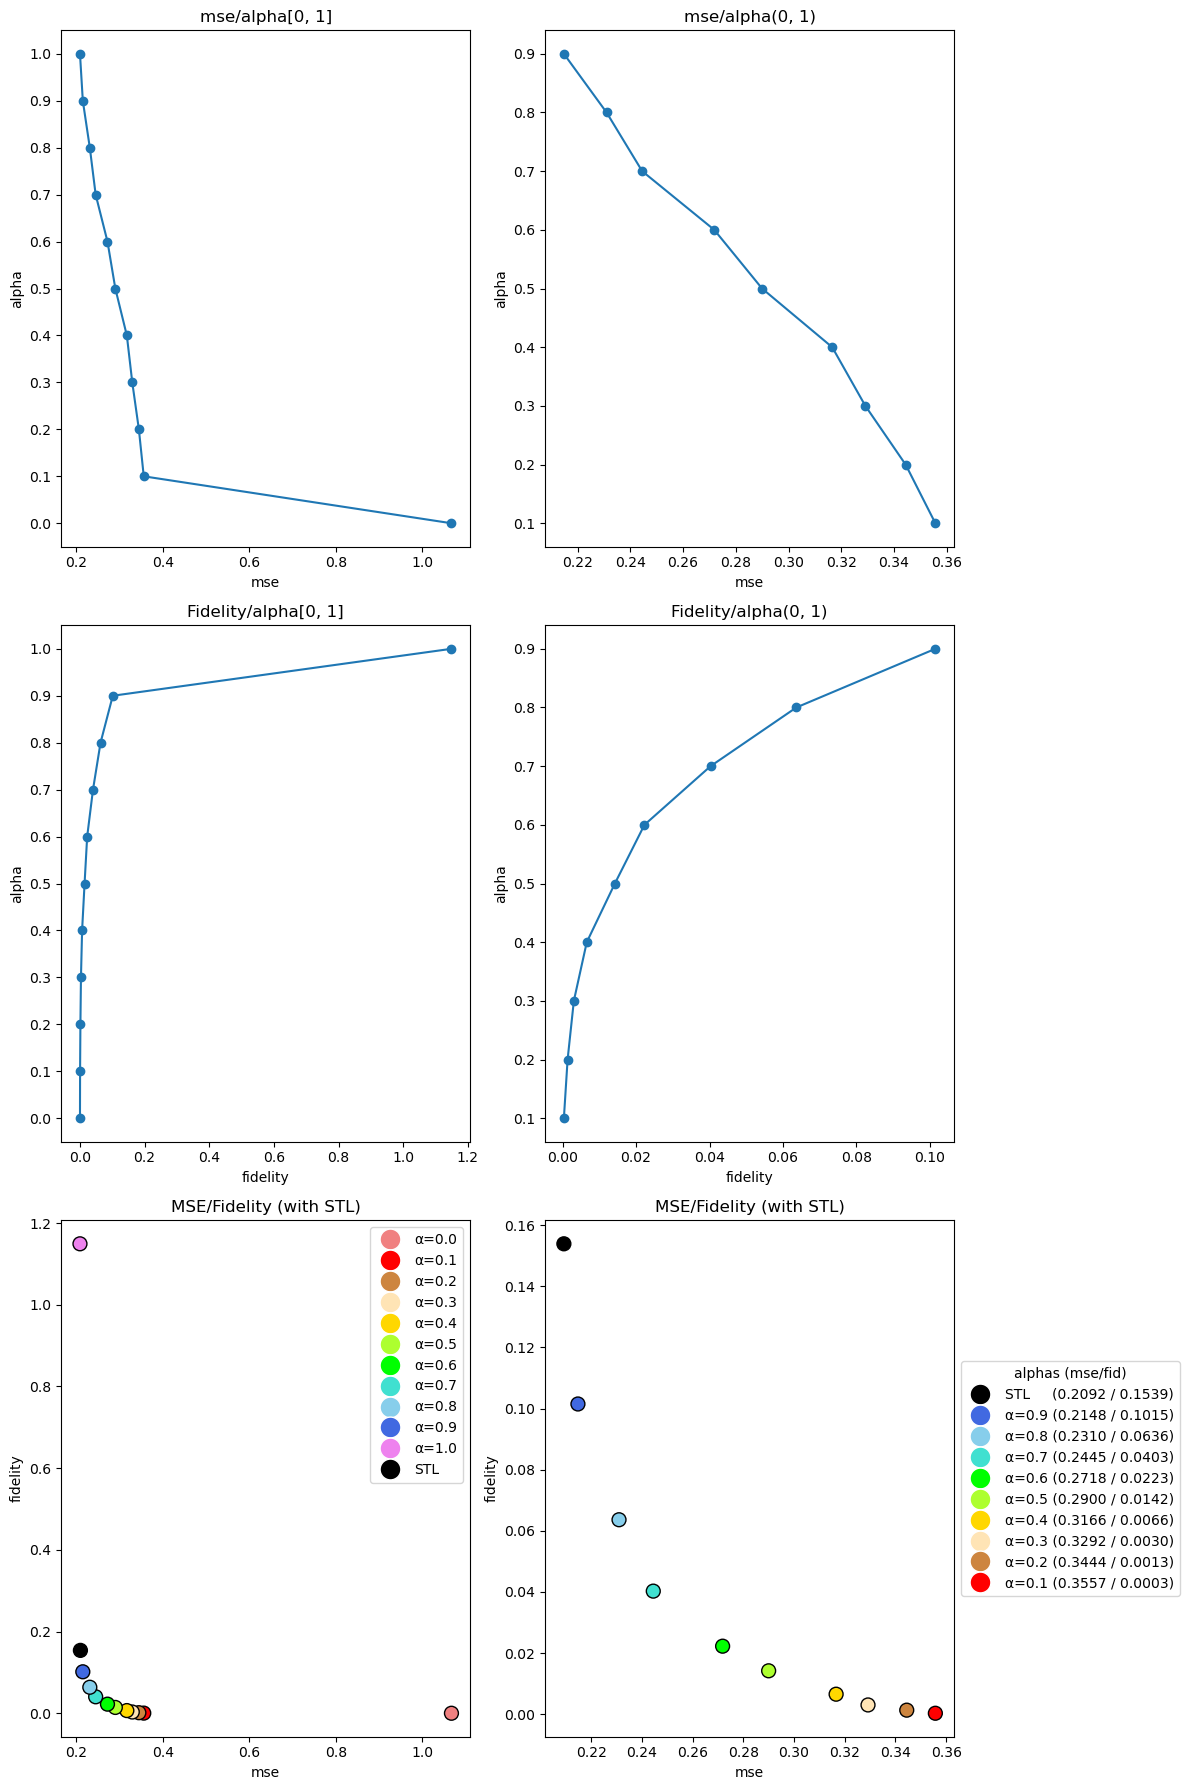

In [74]:
draw_plots_MTL_vs_STL(
    metrics_label='mse',
    metrics_title='MSE',
    config=housing_cfg
)

### Local Explainability Evaluation

Creating Explainer

In [75]:
housing_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=housing_X_train_np,
    mode='regression',
    feature_names=housing_cfg.features.names,
    verbose=False,
    class_names=['Value'],
    categorical_features=housing_cfg.features.categorical_indices,
    categorical_names=housing_cfg.features.values_names,
    discretize_continuous = False
)
housing_explainer

Global Neighborhood Fidelity for STL MLP

In [76]:
# load model
mlp = MLP_reg(input_size=housing_cfg.input_size, hidden_sizes=MLP_reg.get_hidden_sizes(housing_cfg.best_parameters, housing_cfg)).to(housing_cfg.device)
mlp.load_state_dict(torch.load(housing_cfg.models.mlp_opt + '0' + housing_cfg.models.ext))

# prediction functinon
housing_predict_lime = partial(predict_reg_for_lime, model=mlp, config=housing_cfg)

# neighbors dataset
num_rows = 500
housing_indices = torch.randperm(housing_X_test_np.shape[0])[:num_rows]
housing_neighbors_dataset = housing_X_test_np[housing_indices]
print(housing_neighbors_dataset.shape)

if not housing_cfg.results.stl_gnf:
    housing_cfg.results.stl_gnf = global_neighborhood_fidelity_reg(
        model=mlp,
        neighbors_dataset=housing_neighbors_dataset,
        explainer=housing_explainer,
        config=housing_cfg,
        predict_func_lime=housing_predict_lime,
        predict_func_model=predict_reg_for_lime
    )
housing_cfg.results.stl_gnf

(500, 8)


tensor(0.8101, dtype=torch.float64)

Global Neighborhood Fidelity for MTL

In [77]:
if not housing_cfg.results.mtl_gnf:
    global_neighborhood_fidelity_mtl_reg(
        neighbors_dataset=housing_neighbors_dataset,
        explainer=housing_explainer,
        model_params=housing_cfg.best_parameters,
        config=housing_cfg
    )

Model for alpha: 0.0
Model: Housing/mtl_alpha_0.0_0.pt, GNF: 5.269344327843478e-34
Model for alpha: 0.1
Model: Housing/mtl_alpha_0.1_0.pt, GNF: 0.32798953614870613
Model for alpha: 0.2
Model: Housing/mtl_alpha_0.2_0.pt, GNF: 0.2736001213534718
Model for alpha: 0.3
Model: Housing/mtl_alpha_0.3_0.pt, GNF: 0.3408237215788905
Model for alpha: 0.4
Model: Housing/mtl_alpha_0.4_0.pt, GNF: 0.311893750543292
Model for alpha: 0.5
Model: Housing/mtl_alpha_0.5_0.pt, GNF: 0.35479062847954984
Model for alpha: 0.6
Model: Housing/mtl_alpha_0.6_0.pt, GNF: 0.37374903136828697
Model for alpha: 0.7
Model: Housing/mtl_alpha_0.7_0.pt, GNF: 0.40619326174243964
Model for alpha: 0.8
Model: Housing/mtl_alpha_0.8_0.pt, GNF: 0.40350489458037136
Model for alpha: 0.9
Model: Housing/mtl_alpha_0.9_0.pt, GNF: 0.5359144017316437
Model for alpha: 1.0
Model: Housing/mtl_alpha_1.0_0.pt, GNF: 0.799759532004071


In [78]:
show_tables_lime("MSE", housing_cfg) 

Metric,Dataset,Linear,STL,MTL a= 0.0,MTL a= 0.1,MTL a= 0.2,MTL a= 0.3,MTL a= 0.4,MTL a= 0.5,MTL a= 0.6,MTL a= 0.7,MTL a= 0.8,MTL a= 0.9,MTL a= 1.0
MSE,Housing,"0,366","0,210","1,014","0,357","0,351","0,329","0,318","0,291","0,268","0,243","0,233","0,226","0,212"
Global Neighborhood Fidelity,Housing,-,"0,810","0,000","0,328","0,274","0,341","0,312","0,355","0,374","0,406","0,404","0,536","0,800"


## Wine

### Preparation

#### Configuration Settings

In [79]:
wine_cfg = Config(
    folders=Folders(base="Wine/"),
    files=Files(
        data="wine_data.pkl", 
        targets="wine_targets.pkl", 
        study='Wine.plt'
    ),
    training=Training(batch_size=64, num_epochs=750, patience=24),
    tuning=Tuning(num_trials = 50),
)

#### Data Loading and Standardization

In [80]:
# Data Loading
wine_df = pd.read_pickle(wine_cfg.paths.data)

wine_cfg.features.numerical = wine_df.select_dtypes(include='number').columns.values.tolist()
wine_cfg.features.numerical_indices = [wine_df.columns.get_loc(feature) for feature in wine_cfg.features.numerical]
wine_cfg.features.categorical = wine_df.select_dtypes(include='object').columns.values.tolist()
wine_cfg.features.categorical_indices = [wine_df.columns.get_loc(feature) for feature in wine_cfg.features.categorical]
wine_cfg.features.names = wine_df.columns.values.tolist()


# Creating Dictionary 
wine_cfg.features.values_names = {}
for feature, idx in zip(wine_cfg.features.categorical, wine_cfg.features.categorical_indices):
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(wine_df[feature])
    wine_df[feature] = le.transform(wine_df[feature])
    wine_cfg.features.values_names[idx] = le.classes_
    
# Data Splitting
wine_X_train, wine_X_test, wine_y_train, wine_y_test = train_test_split(
    wine_df,
    np.array(pd.read_pickle(wine_cfg.paths.targets)), 
    test_size=0.2, 
    random_state=42
)

wine_X_eval, wine_X_test, wine_y_eval, wine_y_test = train_test_split(
    wine_X_test, 
    wine_y_test, 
    test_size=0.5, 
    random_state=42
)

# Data Scaling
wine_scaler = StandardScaler()
wine_X_train[wine_cfg.features.numerical] = wine_scaler.fit_transform(wine_X_train[wine_cfg.features.numerical]).astype(float)
wine_X_train[wine_cfg.features.categorical] = wine_X_train[wine_cfg.features.categorical].astype(float)

wine_X_eval[wine_cfg.features.numerical] = wine_scaler.transform(wine_X_eval[wine_cfg.features.numerical]).astype(float)
wine_X_eval[wine_cfg.features.categorical] = wine_X_eval[wine_cfg.features.categorical].astype(float)

wine_X_test[wine_cfg.features.numerical] = wine_scaler.transform(wine_X_test[wine_cfg.features.numerical]).astype(float)
wine_X_test[wine_cfg.features.categorical] = wine_X_test[wine_cfg.features.categorical].astype(float)


wine_scaler_y = StandardScaler()
wine_y_train = wine_scaler_y.fit_transform(wine_y_train)
wine_y_eval = wine_scaler_y.transform(wine_y_eval)
wine_y_test = wine_scaler_y.transform(wine_y_test)

# Data Encoding with reindexing to maintain uniform number of columns
wine_cfg.features.dummy = pd.get_dummies(wine_df.astype(float), columns=wine_cfg.features.categorical, dtype=float).columns 

wine_X_train_encoded = pd.get_dummies(wine_X_train, columns=wine_cfg.features.categorical, dtype=float)
wine_X_train_encoded = wine_X_train_encoded.reindex(columns=wine_cfg.features.dummy, fill_value=0.0).values

wine_X_eval_encoded = pd.get_dummies(wine_X_eval, columns=wine_cfg.features.categorical, dtype=float)
wine_X_eval_encoded = wine_X_eval_encoded.reindex(columns=wine_cfg.features.dummy, fill_value=0.0).values

wine_X_test_encoded = pd.get_dummies(wine_X_test, columns=wine_cfg.features.categorical, dtype=float)
wine_X_test_encoded = wine_X_test_encoded.reindex(columns=wine_cfg.features.dummy, fill_value=0.0).values

# Data Conversion 
wine_X_train_tensor = torch.tensor(wine_X_train_encoded, dtype=torch.float32)
wine_X_eval_tensor = torch.tensor(wine_X_eval_encoded, dtype=torch.float32)
wine_X_test_tensor = torch.tensor(wine_X_test_encoded, dtype=torch.float32)

wine_y_train_tensor = torch.tensor(wine_y_train, dtype=torch.float32)
wine_y_eval_tensor = torch.tensor(wine_y_eval, dtype=torch.float32)
wine_y_test_tensor = torch.tensor(wine_y_test, dtype=torch.float32)

wine_X_train_np = wine_X_train.values
wine_X_eval_np = wine_X_eval.values
wine_X_test_np = wine_X_test.values

# Updating Configuration 
wine_cfg.input_size = wine_X_train_tensor.shape[1]
wine_cfg.tuning.min_neurons = wine_cfg.input_size // 4 - 1
wine_cfg.tuning.max_neurons = wine_cfg.input_size * 4 + 1

### Finding Best MLP model

#### Optimization Function

In [81]:
def train_and_optimize_wine(trial, config: Config):
    print(f"Trial: {trial}")
    num_layers = trial.suggest_int(config.tuning.name_layers, config.tuning.min_layers, config.tuning.max_layers)
    hidden_sizes = [trial.suggest_int(f'{config.tuning.name_neurons}{i}', config.tuning.min_neurons, config.tuning.max_neurons) for i in range(num_layers)]

    model = MLP_reg(config.input_size, hidden_sizes, 1)

    mse = train_eval(
        data_train=wine_X_train_tensor,
        target_train=wine_y_train_tensor,
        data_eval=wine_X_eval_tensor,
        target_eval=wine_y_eval_tensor,
        model=model,
        criterion_train=LogHCos(),
        criterion_eval=MSELoss(),
        eval_func=eval_reg,
        direction='min',
        config=config
    )
    return mse

#### Model Optimization

In [82]:
def study_wine(config: Config):
    objective = partial(train_and_optimize_wine, config=config)
    study = optuna.create_study(
        study_name=config.files.study, 
        sampler=config.tuning.sampler(), 
        direction='minimize', 
    )
    study.optimize(objective, n_trials=config.tuning.num_trials, show_progress_bar=True)
    joblib.dump(study, config.paths.study)
    return study

wine_study = try_load_study(study_wine, wine_cfg)

In [83]:
wine_study.trials_dataframe().sort_values("value", ascending=True).head(5)

,number,value,datetime_start,datetime_complete,duration,params_num_layers,params_num_neurons0,params_num_neurons1,params_num_neurons2,params_num_neurons3,params_num_neurons4,state
49,49,0.500179,2024-06-16 19:46:41.289530,2024-06-16 19:46:48.285827,0 days 00:00:06.996297,2,33,26.0,NaN,NaN,NaN,COMPLETE
38,38,0.501622,2024-06-16 19:45:52.677081,2024-06-16 19:45:56.011321,0 days 00:00:03.334240,3,41,42.0,26.0,NaN,NaN,COMPLETE
34,34,0.506471,2024-06-16 19:45:32.638414,2024-06-16 19:45:37.657333,0 days 00:00:05.018919,2,19,32.0,NaN,NaN,NaN,COMPLETE
6,6,0.508746,2024-06-16 19:42:49.899024,2024-06-16 19:42:55.081147,0 days 00:00:05.182123,4,42,7.0,27.0,41.0,NaN,COMPLETE
22,22,0.509504,2024-06-16 19:44:37.561647,2024-06-16 19:44:44.213199,0 days 00:00:06.651552,2,36,22.0,NaN,NaN,NaN,COMPLETE


In [84]:
# study.best_params
print(wine_study.trials[49].value)

wine_cfg.best_parameters = wine_study.trials[49].params
wine_cfg.best_parameters

0.5001788139343262


{'num_layers': 2, 'num_neurons0': 33, 'num_neurons1': 26}

### Training and Testing MLP

In [85]:
train_and_test_mlp_reg(
    X_train=wine_X_train_tensor, 
    y_train=wine_y_train_tensor,
    X_eval=wine_X_eval_tensor, 
    y_eval=wine_y_eval_tensor, 
    X_test=wine_X_test_tensor, 
    y_test=wine_y_test_tensor, 
    config=wine_cfg
)
print(np.mean(list(wine_cfg.results.stl_mlp.values())))
wine_cfg.results.stl_mlp

Model Wine/mlp_opt_0.pt loaded successfully
Model Wine/mlp_opt_1.pt loaded successfully
Model Wine/mlp_opt_2.pt loaded successfully
Model Wine/mlp_opt_3.pt loaded successfully
Model Wine/mlp_opt_4.pt loaded successfully
0.6151364326477051


{0: 0.6342951655387878,
 1: 0.619049608707428,
 2: 0.6095055937767029,
 3: 0.5989424586296082,
 4: 0.6138893365859985}

### Training and Testing Linear Model

In [86]:
train_and_test_lin_reg(
    X_train=wine_X_train_tensor, 
    y_train=wine_y_train_tensor,
    X_eval=wine_X_eval_tensor, 
    y_eval=wine_y_eval_tensor, 
    X_test=wine_X_test_tensor, 
    y_test=wine_y_test_tensor, 
    config=wine_cfg
)
print(np.mean(list(wine_cfg.results.reg.values())))
wine_cfg.results.reg

Model Wine/reg_0.pt loaded successfully
Model Wine/reg_1.pt loaded successfully
Model Wine/reg_2.pt loaded successfully
Model Wine/reg_3.pt loaded successfully
Model Wine/reg_4.pt loaded successfully
0.6499635338783264


{0: 0.6450170278549194,
 1: 0.6487346291542053,
 2: 0.6710107922554016,
 3: 0.6380243301391602,
 4: 0.6470308899879456}

### Training and Testing STL Surogate Model

Train Linear Regression to explain wine_mlp_stl model

In [87]:
train_and_test_stl_lin_reg(
    X_train=wine_X_train_tensor, 
    X_eval=wine_X_eval_tensor, 
    X_test=wine_X_test_tensor, 
    config=wine_cfg
)
print(np.mean(list(wine_cfg.results.stl_reg.values())))
wine_cfg.results.stl_reg

Model Wine/stl_reg_0.pt loaded successfully
Model Wine/stl_reg_1.pt loaded successfully
Model Wine/stl_reg_2.pt loaded successfully
Model Wine/stl_reg_3.pt loaded successfully
Model Wine/stl_reg_4.pt loaded successfully
0.0758777529001236


{0: 0.0976782739162445,
 1: 0.04952423647046089,
 2: 0.11154517531394958,
 3: 0.06276044249534607,
 4: 0.05788063630461693}

### Training and Testing Models in MTL Approach 

MLP + LinReg, alpha in the range of 0 to 1 with a step of 0.1.

In [88]:
train_and_test_mtl_reg(
    X_train=wine_X_train_tensor,
    y_train=wine_y_train_tensor,
    X_eval=wine_X_eval_tensor, 
    y_eval=wine_y_eval_tensor, 
    X_test=wine_X_test_tensor, 
    y_test=wine_y_test_tensor, 
    config=wine_cfg
)
wine_cfg.results.mtl

Model for alpha: 0.0
Model Wine/mtl_alpha_0.0_0.pt loaded successfully
Model: Wine/mtl_alpha_0.0_0.pt, MSE: 1.5097618103027344, Fidelity: 0.00011799861385952681
Model for alpha: 0.1
Model Wine/mtl_alpha_0.1_0.pt loaded successfully
Model: Wine/mtl_alpha_0.1_0.pt, MSE: 0.6537911891937256, Fidelity: 0.00042077319812960923
Model for alpha: 0.2
Model Wine/mtl_alpha_0.2_0.pt loaded successfully
Model: Wine/mtl_alpha_0.2_0.pt, MSE: 0.6304514408111572, Fidelity: 0.0020145683083683252
Model for alpha: 0.3
Model Wine/mtl_alpha_0.3_0.pt loaded successfully
Model: Wine/mtl_alpha_0.3_0.pt, MSE: 0.6398651003837585, Fidelity: 0.005339462775737047
Model for alpha: 0.4
Model Wine/mtl_alpha_0.4_0.pt loaded successfully
Model: Wine/mtl_alpha_0.4_0.pt, MSE: 0.6366544961929321, Fidelity: 0.008599498309195042
Model for alpha: 0.5
Model Wine/mtl_alpha_0.5_0.pt loaded successfully
Model: Wine/mtl_alpha_0.5_0.pt, MSE: 0.6166456937789917, Fidelity: 0.01294360589236021
Model for alpha: 0.6
Model Wine/mtl_alpha_

{0: {'0.0': Result(metrics=1.5097618103027344, fid=0.00011799861385952681),
  '0.1': Result(metrics=0.6537911891937256, fid=0.00042077319812960923),
  '0.2': Result(metrics=0.6304514408111572, fid=0.0020145683083683252),
  '0.3': Result(metrics=0.6398651003837585, fid=0.005339462775737047),
  '0.4': Result(metrics=0.6366544961929321, fid=0.008599498309195042),
  '0.5': Result(metrics=0.6166456937789917, fid=0.01294360589236021),
  '0.6': Result(metrics=0.6293395757675171, fid=0.01913323625922203),
  '0.7': Result(metrics=0.6063622832298279, fid=0.01957966573536396),
  '0.8': Result(metrics=0.6100016236305237, fid=0.036316681653261185),
  '0.9': Result(metrics=0.608390212059021, fid=0.057214800268411636),
  '1.0': Result(metrics=0.6503323912620544, fid=1.2645364999771118)},
 1: {'0.0': Result(metrics=1.5723340511322021, fid=1.338172205578303e-05),
  '0.1': Result(metrics=0.641777515411377, fid=0.00039722162182442844),
  '0.2': Result(metrics=0.6426250338554382, fid=0.002357028191909194)

### Comparison of STL with MTL

In [89]:
show_tables("MSE", wine_cfg) 

Metric,Dataset,Linear,Non-linear (MLP)
MSE,Wine,"0,6500","0,6151"


Metric,Dataset,Linear,STL,MTL a= 0.0,MTL a= 0.1,MTL a= 0.2,MTL a= 0.3,MTL a= 0.4,MTL a= 0.5,MTL a= 0.6,MTL a= 0.7,MTL a= 0.8,MTL a= 0.9,MTL a= 1.0
MSE,Wine,"0,6500","0,6151","1,3796","0,6488","0,6327","0,6470","0,6277","0,6283","0,6313","0,6125","0,6108","0,6116","0,6276"
Global Fidelity,Wine,-,"0,0759","0,0000","0,0005","0,0019","0,0044","0,0085","0,0136","0,0179","0,0278","0,0359","0,0611","1,0441"


<class 'numpy.float64'>


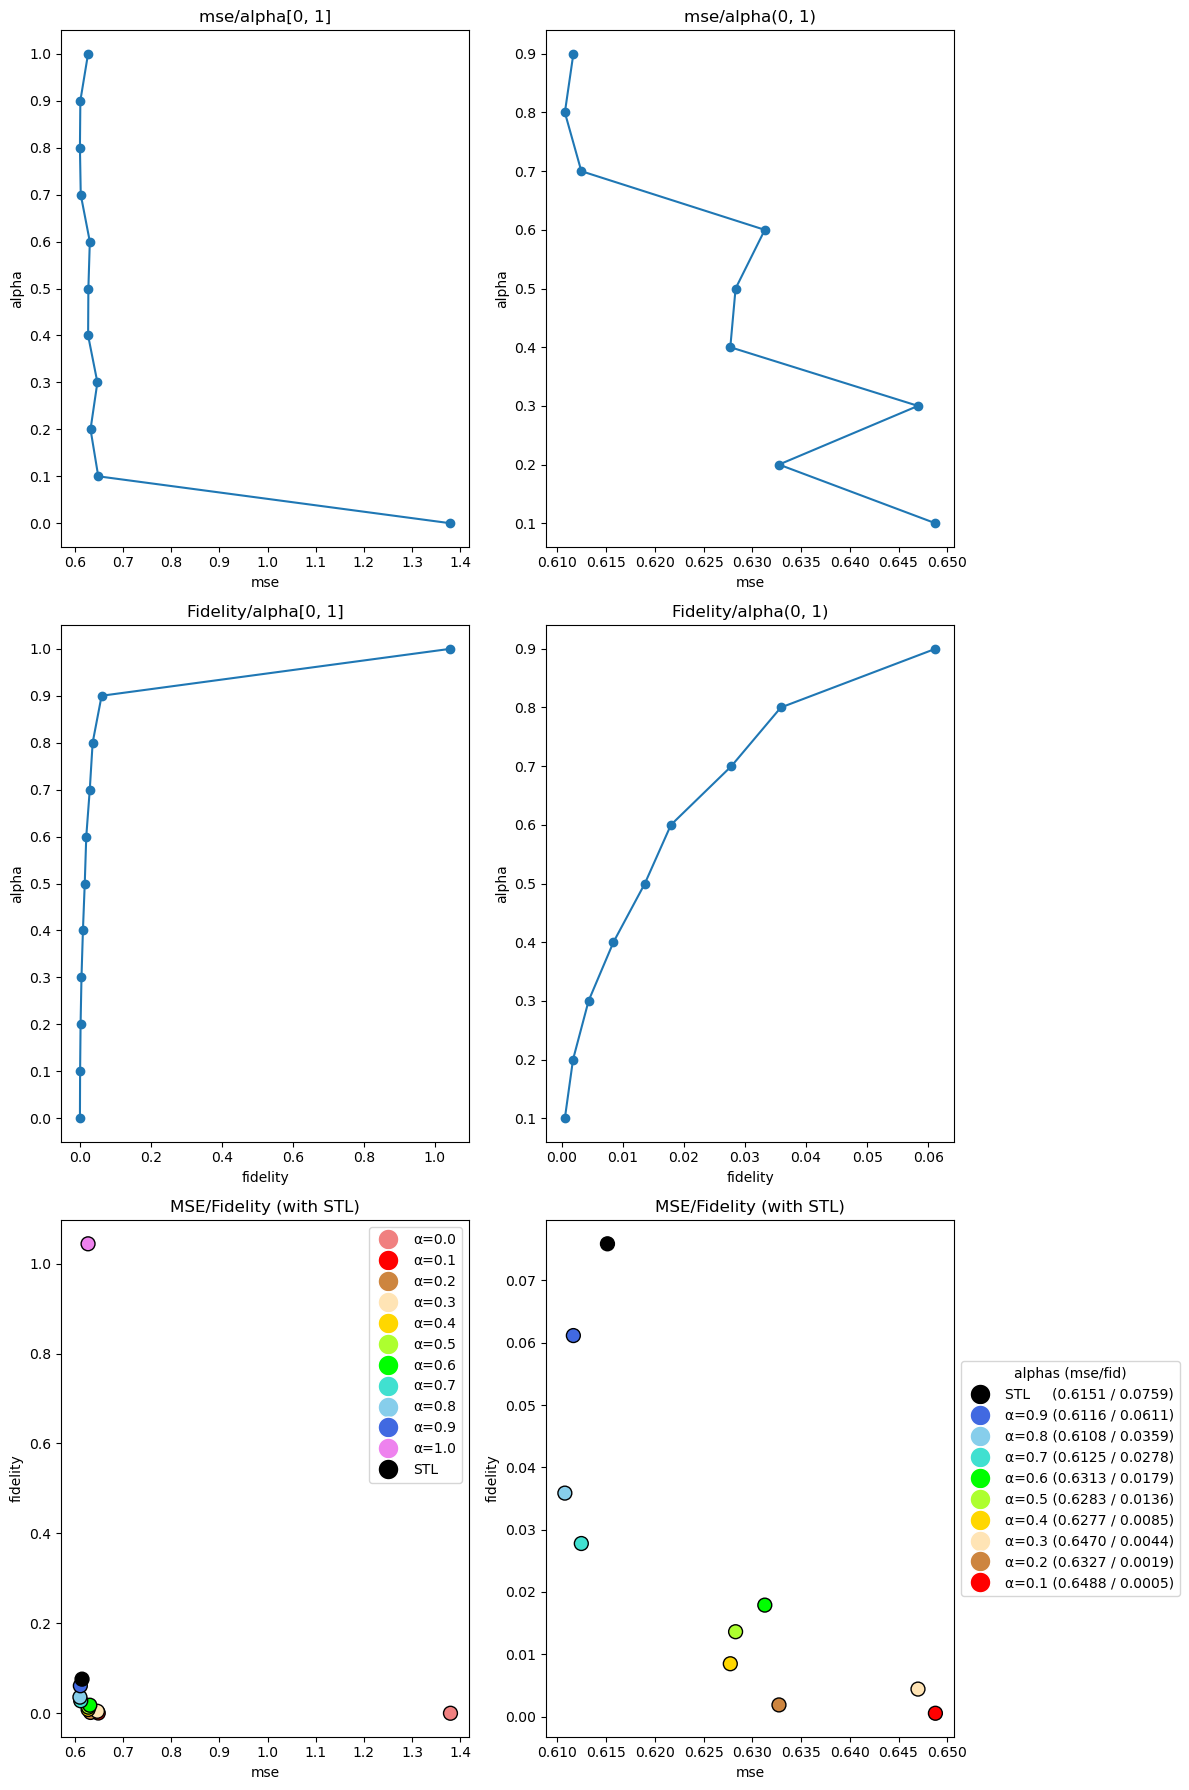

In [90]:
draw_plots_MTL_vs_STL(
    metrics_label='mse',
    metrics_title='MSE',
    config=wine_cfg
)

### Local Explainability Evaluation

Creating Explainer

In [91]:
wine_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=wine_X_train_np,
    mode='regression',
    feature_names=wine_cfg.features.names,
    verbose=False,
    class_names=['quality'],
    categorical_features=wine_cfg.features.categorical_indices,
    categorical_names=wine_cfg.features.values_names,
    discretize_continuous=False
)
wine_explainer

Global Neighborhood Fidelity for STL MLP

In [92]:
# load model
mlp = MLP_reg(input_size=wine_cfg.input_size, hidden_sizes=MLP_reg.get_hidden_sizes(wine_cfg.best_parameters, wine_cfg)).to(wine_cfg.device)
mlp.load_state_dict(torch.load(wine_cfg.models.mlp_opt + '0' + wine_cfg.models.ext))

# prediction function
wine_predict_lime = partial(predict_reg_for_lime, model=mlp, config=wine_cfg)

# neighbors dataset
wine_neighbors_dataset = wine_X_test_np
print(wine_neighbors_dataset.shape)

if not wine_cfg.results.stl_gnf:
    wine_cfg.results.stl_gnf = global_neighborhood_fidelity_reg(
        model=mlp,
        neighbors_dataset=wine_neighbors_dataset,
        explainer=wine_explainer,
        config=wine_cfg,
        predict_func_lime=wine_predict_lime,
        predict_func_model=predict_reg_for_lime
    )
wine_cfg.results.stl_gnf

(136, 11)


tensor(0.1446, dtype=torch.float64)

Global Neighborhood Fidelity for MTL

In [93]:
if not wine_cfg.results.mtl_gnf:
    global_neighborhood_fidelity_mtl_reg(
        neighbors_dataset=wine_neighbors_dataset,
        explainer=wine_explainer,
        model_params=wine_cfg.best_parameters,
        config=wine_cfg
    )

Model for alpha: 0.0
Model: Wine/mtl_alpha_0.0_0.pt, GNF: 0.026466430475704752
Model for alpha: 0.1
Model: Wine/mtl_alpha_0.1_0.pt, GNF: 0.035418617634295234
Model for alpha: 0.2
Model: Wine/mtl_alpha_0.2_0.pt, GNF: 0.04633843036663557
Model for alpha: 0.3
Model: Wine/mtl_alpha_0.3_0.pt, GNF: 0.04750656565939461
Model for alpha: 0.4
Model: Wine/mtl_alpha_0.4_0.pt, GNF: 0.06839925348691395
Model for alpha: 0.5
Model: Wine/mtl_alpha_0.5_0.pt, GNF: 0.06097740613538504
Model for alpha: 0.6
Model: Wine/mtl_alpha_0.6_0.pt, GNF: 0.07580435477375733
Model for alpha: 0.7
Model: Wine/mtl_alpha_0.7_0.pt, GNF: 0.057309012547154495
Model for alpha: 0.8
Model: Wine/mtl_alpha_0.8_0.pt, GNF: 0.07823389182276423
Model for alpha: 0.9
Model: Wine/mtl_alpha_0.9_0.pt, GNF: 0.11866506101091472
Model for alpha: 1.0
Model: Wine/mtl_alpha_1.0_0.pt, GNF: 0.24642455415437703


In [94]:
show_tables_lime("MSE", wine_cfg) 

Metric,Dataset,Linear,STL,MTL a= 0.0,MTL a= 0.1,MTL a= 0.2,MTL a= 0.3,MTL a= 0.4,MTL a= 0.5,MTL a= 0.6,MTL a= 0.7,MTL a= 0.8,MTL a= 0.9,MTL a= 1.0
MSE,Wine,"0,645","0,634","1,510","0,654","0,630","0,640","0,637","0,617","0,629","0,606","0,610","0,608","0,650"
Global Neighborhood Fidelity,Wine,-,"0,145","0,026","0,035","0,046","0,048","0,068","0,061","0,076","0,057","0,078","0,119","0,246"


## Adult

### Preparation

#### Configuration Settings

In [95]:
adult_cfg = Config(
    folders=Folders(base="Adult/"),
    files=Files(
        data="adult_data.pkl", 
        targets="adult_targets.pkl", 
        study='Adult.plt'
    ),
    training=Training(batch_size=64),
    tuning=Tuning(num_trials = 25)
)

#### Data Loading and Standardization

In [96]:
# Data Loading
adult_df = pd.read_pickle(adult_cfg.paths.data)

adult_cfg.features.numerical = adult_df.select_dtypes(include='number').columns.values.tolist()
adult_cfg.features.numerical_indices = [adult_df.columns.get_loc(feature) for feature in adult_cfg.features.numerical]
adult_cfg.features.categorical = adult_df.select_dtypes(include='object').columns.values.tolist()
adult_cfg.features.categorical_indices = [adult_df.columns.get_loc(feature) for feature in adult_cfg.features.categorical]
adult_cfg.features.names = adult_df.columns.values.tolist()


# Creating Dictionary 
adult_cfg.features.values_names = {}
for feature, idx in zip(adult_cfg.features.categorical, adult_cfg.features.categorical_indices):
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(adult_df[feature])
    adult_df[feature] = le.transform(adult_df[feature])
    adult_cfg.features.values_names[idx] = le.classes_
    
# Data Splitting
adult_X_train, adult_X_test, adult_y_train, adult_y_test = train_test_split(
    adult_df,
    np.array(pd.read_pickle(adult_cfg.paths.targets)), 
    test_size=0.2, 
    random_state=42
)

adult_X_eval, adult_X_test, adult_y_eval, adult_y_test = train_test_split(
    adult_X_test, 
    adult_y_test, 
    test_size=0.5, 
    random_state=42
)

# Data Scaling
adult_scaler = StandardScaler()
adult_X_train[adult_cfg.features.numerical] = adult_scaler.fit_transform(adult_X_train[adult_cfg.features.numerical]).astype(float)
adult_X_train[adult_cfg.features.categorical] = adult_X_train[adult_cfg.features.categorical].astype(float)

adult_X_eval[adult_cfg.features.numerical] = adult_scaler.transform(adult_X_eval[adult_cfg.features.numerical]).astype(float)
adult_X_eval[adult_cfg.features.categorical] = adult_X_eval[adult_cfg.features.categorical].astype(float)

adult_X_test[adult_cfg.features.numerical] = adult_scaler.transform(adult_X_test[adult_cfg.features.numerical]).astype(float)
adult_X_test[adult_cfg.features.categorical] = adult_X_test[adult_cfg.features.categorical].astype(float)

# Data Encoding with reindexing to maintain uniform number of columns
adult_cfg.features.dummy = pd.get_dummies(adult_df.astype(float), columns=adult_cfg.features.categorical, dtype=float).columns 

adult_X_train_encoded = pd.get_dummies(adult_X_train, columns=adult_cfg.features.categorical, dtype=float)
adult_X_train_encoded = adult_X_train_encoded.reindex(columns=adult_cfg.features.dummy, fill_value=0.0).values

adult_X_eval_encoded = pd.get_dummies(adult_X_eval, columns=adult_cfg.features.categorical, dtype=float)
adult_X_eval_encoded = adult_X_eval_encoded.reindex(columns=adult_cfg.features.dummy, fill_value=0.0).values

adult_X_test_encoded = pd.get_dummies(adult_X_test, columns=adult_cfg.features.categorical, dtype=float)
adult_X_test_encoded = adult_X_test_encoded.reindex(columns=adult_cfg.features.dummy, fill_value=0.0).values

# Data Conversion 
adult_X_train_tensor = torch.tensor(adult_X_train_encoded, dtype=torch.float32)
adult_X_eval_tensor = torch.tensor(adult_X_eval_encoded, dtype=torch.float32)
adult_X_test_tensor = torch.tensor(adult_X_test_encoded, dtype=torch.float32)

adult_y_train_tensor = torch.tensor(adult_y_train, dtype=torch.float32)
adult_y_eval_tensor = torch.tensor(adult_y_eval, dtype=torch.float32)
adult_y_test_tensor = torch.tensor(adult_y_test, dtype=torch.float32)

adult_X_train_np = adult_X_train.values
adult_X_eval_np = adult_X_eval.values
adult_X_test_np = adult_X_test.values

# Updating Configuration 
adult_cfg.input_size = adult_X_train_tensor.shape[1]
adult_cfg.tuning.min_neurons = adult_cfg.input_size // 4 - 1
adult_cfg.tuning.max_neurons = adult_cfg.input_size * 4 + 1

### Finding Best MLP model

#### Optimization Function

In [97]:
def train_and_optimize_adult(trial, config: Config):
    print(f"Trial: {trial}")
    num_layers = trial.suggest_int(config.tuning.name_layers, config.tuning.min_layers, config.tuning.max_layers)
    hidden_sizes = [trial.suggest_int(f'{config.tuning.name_neurons}{i}', config.tuning.min_neurons, config.tuning.max_neurons) for i in range(num_layers)]

    model = MLP_cls(config.input_size, hidden_sizes, 1)

    acc = train_eval(
        data_train=adult_X_train,
        target_train=adult_y_train,
        data_eval=adult_X_eval,
        target_eval=adult_y_eval,
        model=model,
        criterion_train=BCELoss(),
        criterion_eval=AccuracyScore(),
        eval_func=eval_cls,
        direction='max',
        config=config
    )
    return acc

#### Model Optimization

In [98]:
def study_adult(config: Config):
    objective = partial(train_and_optimize_adult, config=config)
    study = optuna.create_study(
        study_name=config.files.study, 
        sampler=config.tuning.sampler(), 
        direction='maximize', 
    )
    study.optimize(objective, n_trials=config.tuning.num_trials, show_progress_bar=True)
    joblib.dump(study, config.paths.study)
    return study

adult_study = try_load_study(study_adult, adult_cfg)

In [99]:
adult_study.trials_dataframe().sort_values("value", ascending=False).head(5)

,number,value,datetime_start,datetime_complete,duration,params_num_layers,params_num_neurons0,params_num_neurons1,params_num_neurons2,params_num_neurons3,params_num_neurons4,state
4,4,0.856163,2024-06-06 00:53:00.551012,2024-06-06 00:54:06.049463,0 days 00:01:05.498451,5,188,328.0,130.0,151.0,160.0,COMPLETE
23,23,0.855942,2024-06-06 01:03:16.410166,2024-06-06 01:03:42.831384,0 days 00:00:26.421218,5,24,309.0,357.0,136.0,412.0,COMPLETE
19,19,0.855720,2024-06-06 01:01:35.333610,2024-06-06 01:02:00.410683,0 days 00:00:25.077073,4,117,403.0,278.0,265.0,NaN,COMPLETE
9,9,0.855499,2024-06-06 00:57:12.644184,2024-06-06 00:57:43.100848,0 days 00:00:30.456664,2,30,82.0,NaN,NaN,NaN,COMPLETE
24,24,0.855278,2024-06-06 01:03:42.833379,2024-06-06 01:04:11.797519,0 days 00:00:28.964140,5,140,295.0,367.0,137.0,407.0,COMPLETE


Due to relatively small differences in accuracy and to speed up further training, I choose the model from trial number nine.

In [100]:
# study.best_params
print(adult_study.trials[9].value)

adult_cfg.best_parameters = adult_study.trials[9].params
adult_cfg.best_parameters

0.8554989695549011


{'num_layers': 2, 'num_neurons0': 30, 'num_neurons1': 82}

### Training and Testing MLP

In [101]:
train_and_test_mlp_cls(
    X_train=adult_X_train_tensor, 
    y_train=adult_y_train_tensor,
    X_eval=adult_X_eval_tensor, 
    y_eval=adult_y_eval_tensor, 
    X_test=adult_X_test_tensor, 
    y_test=adult_y_test_tensor, 
    config=adult_cfg
)
print(np.mean(list(adult_cfg.results.stl_mlp.values())))
adult_cfg.results.stl_mlp

Model Adult/mlp_opt_0.pt loaded successfully
Model Adult/mlp_opt_1.pt loaded successfully
Model Adult/mlp_opt_2.pt loaded successfully
Model Adult/mlp_opt_3.pt loaded successfully
Model Adult/mlp_opt_4.pt loaded successfully
0.8521238923072815


{0: 0.8504424691200256,
 1: 0.8539822697639465,
 2: 0.8537610769271851,
 3: 0.8546460270881653,
 4: 0.847787618637085}

### Training and Testing Linear Model

In [102]:
train_and_test_lin_cls(
    X_train=adult_X_train_tensor, 
    y_train=adult_y_train_tensor,
    X_eval=adult_X_eval_tensor, 
    y_eval=adult_y_eval_tensor, 
    X_test=adult_X_test_tensor, 
    y_test=adult_y_test_tensor, 
    config=adult_cfg
)
print(np.mean(list(adult_cfg.results.reg.values())))
adult_cfg.results.reg

Model Adult/reg_0.pt loaded successfully
Model Adult/reg_1.pt loaded successfully
Model Adult/reg_2.pt loaded successfully
Model Adult/reg_3.pt loaded successfully
Model Adult/reg_4.pt loaded successfully
0.8503097295761108


{0: 0.8495575189590454,
 1: 0.8508849740028381,
 2: 0.8502212166786194,
 3: 0.8502212166786194,
 4: 0.8506637215614319}

### Training and Testing STL Surogate Model

Train Logistic Regression to explain adult_mlp_stl model

In [103]:
train_and_test_stl_lin_cls(
    X_train=adult_X_train_tensor, 
    X_eval=adult_X_eval_tensor, 
    X_test=adult_X_test_tensor, 
    config=adult_cfg
)
print(np.mean(list(adult_cfg.results.stl_reg.values())))
adult_cfg.results.stl_reg

Model Adult/stl_reg_0.pt loaded successfully
Model Adult/stl_reg_1.pt loaded successfully
Model Adult/stl_reg_2.pt loaded successfully
Model Adult/stl_reg_3.pt loaded successfully
Model Adult/stl_reg_4.pt loaded successfully
0.039513275027275085


{0: 0.036283187568187714,
 1: 0.037831857800483704,
 2: 0.04712389409542084,
 3: 0.04115044325590134,
 4: 0.035176992416381836}

### Training and Testing Models in MTL Approach 

MLP + LinReg, alpha in the range of 0 to 1 with a step of 0.1.

In [104]:
train_and_test_mtl_cls(
    X_train=adult_X_train_tensor,
    y_train=adult_y_train_tensor,
    X_eval=adult_X_eval_tensor, 
    y_eval=adult_y_eval_tensor, 
    X_test=adult_X_test_tensor, 
    y_test=adult_y_test_tensor, 
    config=adult_cfg
)
adult_cfg.results.mtl

Model for alpha: 0.0
Model Adult/mtl_alpha_0.0_0.pt loaded successfully
Result on test dataset: Adult/mtl_alpha_0.0_0.pt, Accuracy: 0.7453539967536926, Fidelity: 0.00022123893722891808
Model for alpha: 0.1
Model Adult/mtl_alpha_0.1_0.pt loaded successfully
Result on test dataset: Adult/mtl_alpha_0.1_0.pt, Accuracy: 0.8522123694419861, Fidelity: 0.014601769857108593
Model for alpha: 0.2
Model Adult/mtl_alpha_0.2_0.pt loaded successfully
Result on test dataset: Adult/mtl_alpha_0.2_0.pt, Accuracy: 0.8548672795295715, Fidelity: 0.02101769857108593
Model for alpha: 0.3
Model Adult/mtl_alpha_0.3_0.pt loaded successfully
Result on test dataset: Adult/mtl_alpha_0.3_0.pt, Accuracy: 0.8513274192810059, Fidelity: 0.02544247731566429
Model for alpha: 0.4
Model Adult/mtl_alpha_0.4_0.pt loaded successfully
Result on test dataset: Adult/mtl_alpha_0.4_0.pt, Accuracy: 0.8537610769271851, Fidelity: 0.027654867619276047
Model for alpha: 0.5
Model Adult/mtl_alpha_0.5_0.pt loaded successfully
Result on tes

{0: {'0.0': Result(metrics=0.7453539967536926, fid=0.00022123893722891808),
  '0.1': Result(metrics=0.8522123694419861, fid=0.014601769857108593),
  '0.2': Result(metrics=0.8548672795295715, fid=0.02101769857108593),
  '0.3': Result(metrics=0.8513274192810059, fid=0.02544247731566429),
  '0.4': Result(metrics=0.8537610769271851, fid=0.027654867619276047),
  '0.5': Result(metrics=0.8537610769271851, fid=0.03362831845879555),
  '0.6': Result(metrics=0.8515486717224121, fid=0.03761062026023865),
  '0.7': Result(metrics=0.8535398244857788, fid=0.038274336606264114),
  '0.8': Result(metrics=0.854424774646759, fid=0.04446902498602867),
  '0.9': Result(metrics=0.854424774646759, fid=0.04911504313349724),
  '1.0': Result(metrics=0.8539822697639465, fid=0.4590708017349243)},
 1: {'0.0': Result(metrics=0.6670354008674622, fid=0.002433628309518099),
  '0.1': Result(metrics=0.8506637215614319, fid=0.011946902610361576),
  '0.2': Result(metrics=0.854424774646759, fid=0.020353982225060463),
  '0.3':

### Comparison of STL with MTL

In [105]:
show_tables("MSE", adult_cfg) 

Metric,Dataset,Linear,Non-linear (MLP)
MSE,Adult,"0,8503","0,8521"


Metric,Dataset,Linear,STL,MTL a= 0.0,MTL a= 0.1,MTL a= 0.2,MTL a= 0.3,MTL a= 0.4,MTL a= 0.5,MTL a= 0.6,MTL a= 0.7,MTL a= 0.8,MTL a= 0.9,MTL a= 1.0
MSE,Adult,"0,8503","0,8521","0,5359","0,8528","0,8530","0,8511","0,8537","0,8535","0,8525","0,8543","0,8524","0,8542","0,8537"
Global Fidelity,Adult,-,"0,0395","0,0006","0,0131","0,0210","0,0257","0,0317","0,0337","0,0356","0,0383","0,0426","0,0454","0,3703"


<class 'numpy.float64'>


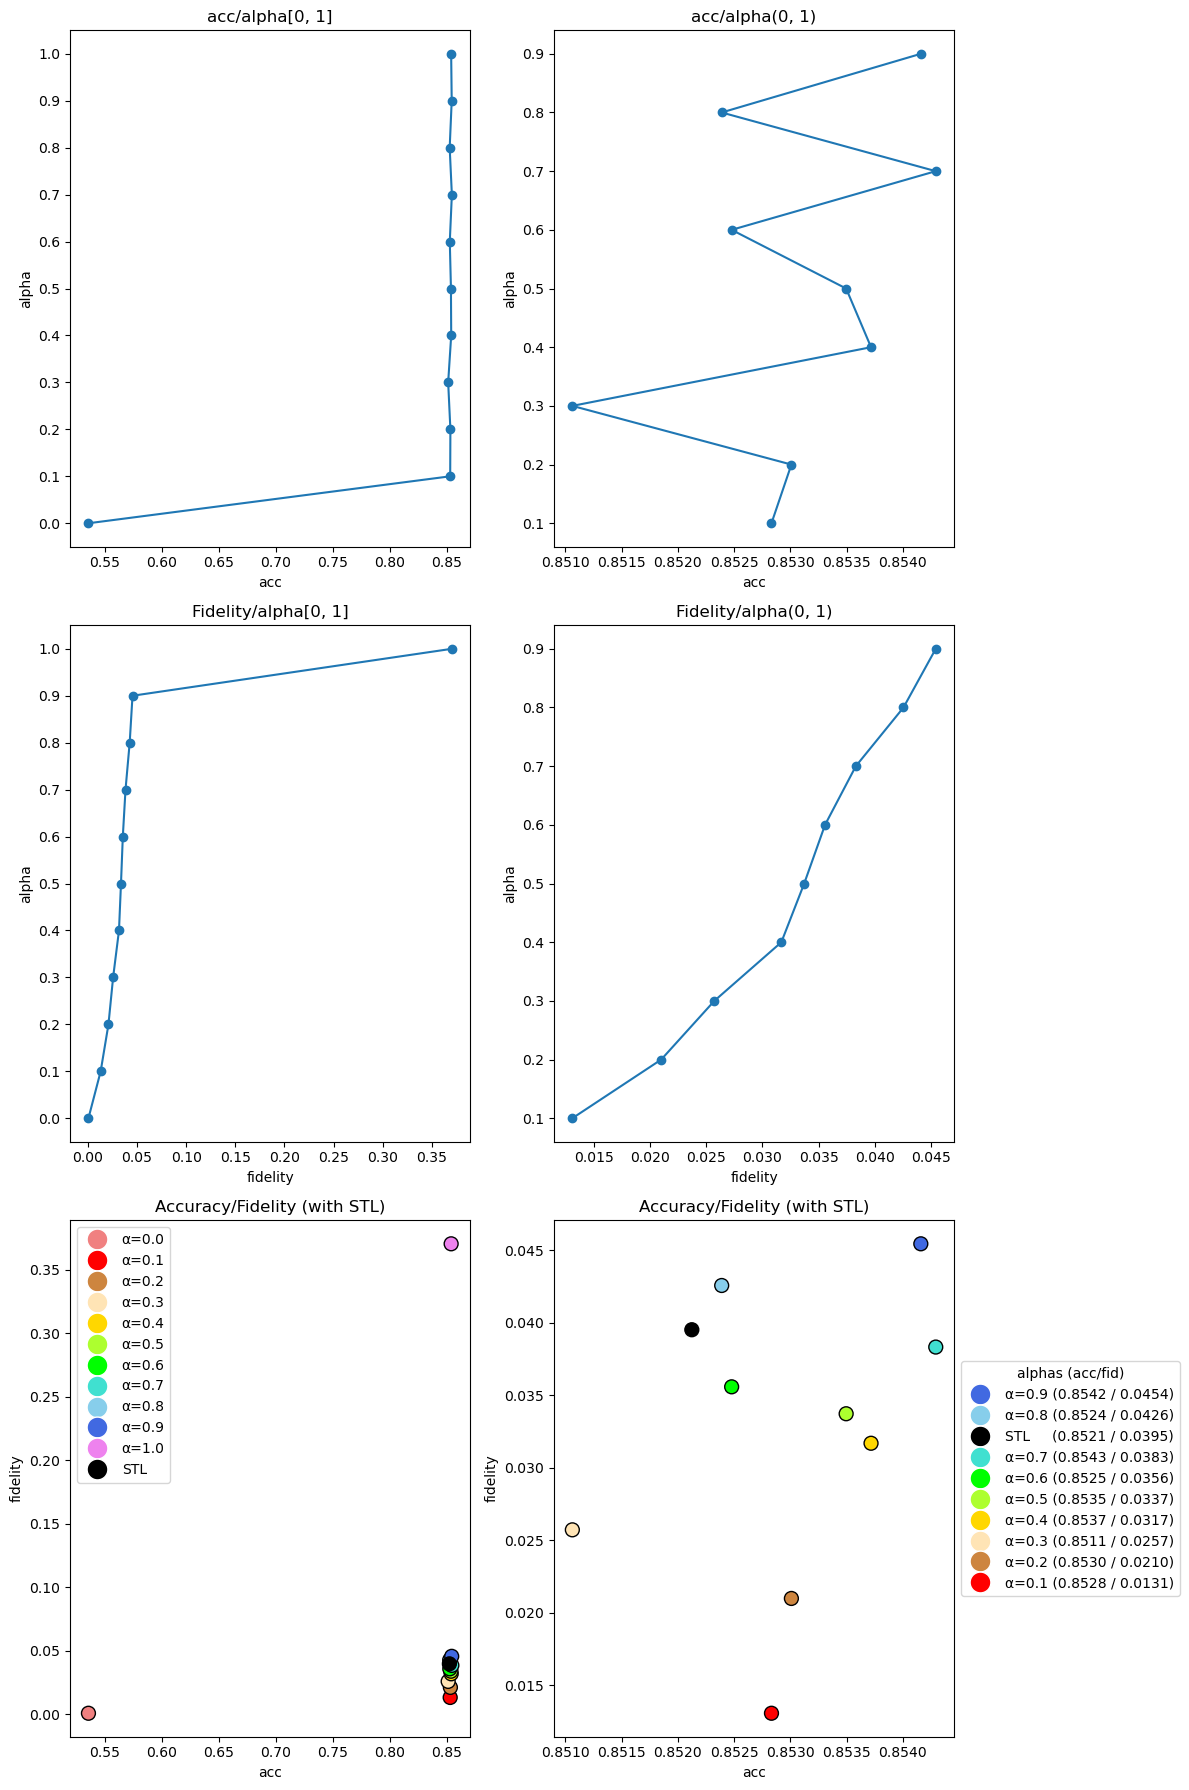

In [106]:
draw_plots_MTL_vs_STL(
    metrics_label='acc',
    metrics_title='Accuracy',
    config=adult_cfg
)

### Local Explainability Evaluation

Creating Explainer

In [107]:
adult_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=adult_X_train_np,
    mode='classification',
    feature_names=adult_cfg.features.names,
    verbose=False,
    class_names=['below 50k', 'above 50k'],
    categorical_features=adult_cfg.features.categorical_indices,
    categorical_names=adult_cfg.features.values_names,
    discretize_continuous=False
)
adult_explainer

Global Neighborhood Fidelity for STL MLP

In [108]:
# load model
mlp = MLP_cls(input_size=adult_cfg.input_size, hidden_sizes=MLP_cls.get_hidden_sizes(adult_cfg.best_parameters, adult_cfg)).to(adult_cfg.device)
mlp.load_state_dict(torch.load(adult_cfg.models.mlp_opt + '0' + adult_cfg.models.ext))

# prediction function
adult_predict_lime = partial(predict_cls_for_lime, model=mlp, config=adult_cfg)

# neighbors dataset
num_rows = 500
adult_indices = torch.randperm(adult_X_test_np.shape[0])[:num_rows]
adult_neighbors_dataset = adult_X_test_np[adult_indices]
print(adult_neighbors_dataset.shape)


adult_cfg.results.stl_gnf = global_neighborhood_fidelity_cls(
    model=mlp,
    neighbors_dataset=adult_neighbors_dataset,
    explainer=adult_explainer,
    config=adult_cfg,
    predict_func_lime=adult_predict_lime,
    predict_func_model=predict_cls_for_lime
)
adult_cfg.results.stl_gnf

(500, 13)


tensor(0.1506)

Global Neighborhood Fidelity for MTL

In [109]:
global_neighborhood_fidelity_mtl_cls(
    neighbors_dataset=adult_neighbors_dataset,
    explainer=adult_explainer,
    model_params=adult_cfg.best_parameters,
    config=adult_cfg
)

Model for alpha: 0.0
Model: Adult/mtl_alpha_0.0_0.pt, GNF: 0.0
Model for alpha: 0.1
Model: Adult/mtl_alpha_0.1_0.pt, GNF: 0.21079999208450317
Model for alpha: 0.2
Model: Adult/mtl_alpha_0.2_0.pt, GNF: 0.22540001571178436
Model for alpha: 0.3
Model: Adult/mtl_alpha_0.3_0.pt, GNF: 0.17240001261234283
Model for alpha: 0.4
Model: Adult/mtl_alpha_0.4_0.pt, GNF: 0.19219999015331268
Model for alpha: 0.5
Model: Adult/mtl_alpha_0.5_0.pt, GNF: 0.15199999511241913
Model for alpha: 0.6
Model: Adult/mtl_alpha_0.6_0.pt, GNF: 0.18040001392364502
Model for alpha: 0.7
Model: Adult/mtl_alpha_0.7_0.pt, GNF: 0.17980001866817474
Model for alpha: 0.8
Model: Adult/mtl_alpha_0.8_0.pt, GNF: 0.1979999989271164
Model for alpha: 0.9
Model: Adult/mtl_alpha_0.9_0.pt, GNF: 0.16459999978542328
Model for alpha: 1.0
Model: Adult/mtl_alpha_1.0_0.pt, GNF: 0.2197999805212021


In [110]:
show_tables_lime("Accuracy", adult_cfg) 

Metric,Dataset,Linear,STL,MTL a= 0.0,MTL a= 0.1,MTL a= 0.2,MTL a= 0.3,MTL a= 0.4,MTL a= 0.5,MTL a= 0.6,MTL a= 0.7,MTL a= 0.8,MTL a= 0.9,MTL a= 1.0
Accuracy,Adult,"0,850","0,850","0,745","0,852","0,855","0,851","0,854","0,854","0,852","0,854","0,854","0,854","0,854"
Global Neighborhood Fidelity,Adult,-,"0,151","0,000","0,211","0,225","0,172","0,192","0,152","0,180","0,180","0,198","0,165","0,220"


## Titanic

### Preparation

#### Configuration Settings

In [111]:
titanic_cfg = Config(
    folders=Folders(base="Titanic/"),
    files=Files(
        data="titanic_data.pkl", 
        targets="titanic_targets.pkl", 
        study='Titanic.plt'
    ),
    training=Training(batch_size=64, num_epochs=500, patience=24),
    tuning=Tuning(num_trials = 50),
)

#### Data Loading and Standardization

In [112]:
# Data Loading
titanic_df = pd.read_pickle(titanic_cfg.paths.data)

titanic_cfg.features.numerical = titanic_df.select_dtypes(include='number').columns.values.tolist()
titanic_cfg.features.numerical_indices = [titanic_df.columns.get_loc(feature) for feature in titanic_cfg.features.numerical]
titanic_cfg.features.categorical = titanic_df.select_dtypes(include='object').columns.values.tolist()
titanic_cfg.features.categorical_indices = [titanic_df.columns.get_loc(feature) for feature in titanic_cfg.features.categorical]
titanic_cfg.features.names = titanic_df.columns.values.tolist()


# Creating Dictionary 
titanic_cfg.features.values_names = {}
for feature, idx in zip(titanic_cfg.features.categorical, titanic_cfg.features.categorical_indices):
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(titanic_df[feature])
    titanic_df[feature] = le.transform(titanic_df[feature])
    titanic_cfg.features.values_names[idx] = le.classes_
    
# Data Splitting
titanic_X_train, titanic_X_test, titanic_y_train, titanic_y_test = train_test_split(
    titanic_df,
    np.array(pd.read_pickle(titanic_cfg.paths.targets)), 
    test_size=0.2, 
    random_state=42
)

titanic_X_eval, titanic_X_test, titanic_y_eval, titanic_y_test = train_test_split(
    titanic_X_test, 
    titanic_y_test, 
    test_size=0.5, 
    random_state=42
)

# Data Scaling
titanic_scaler = StandardScaler()
titanic_X_train[titanic_cfg.features.numerical] = titanic_scaler.fit_transform(titanic_X_train[titanic_cfg.features.numerical]).astype(float)
titanic_X_train[titanic_cfg.features.categorical] = titanic_X_train[titanic_cfg.features.categorical].astype(float)

titanic_X_eval[titanic_cfg.features.numerical] = titanic_scaler.transform(titanic_X_eval[titanic_cfg.features.numerical]).astype(float)
titanic_X_eval[titanic_cfg.features.categorical] = titanic_X_eval[titanic_cfg.features.categorical].astype(float)

titanic_X_test[titanic_cfg.features.numerical] = titanic_scaler.transform(titanic_X_test[titanic_cfg.features.numerical]).astype(float)
titanic_X_test[titanic_cfg.features.categorical] = titanic_X_test[titanic_cfg.features.categorical].astype(float)

# Data Encoding with reindexing to maintain uniform number of columns
titanic_cfg.features.dummy = pd.get_dummies(titanic_df.astype(float), columns=titanic_cfg.features.categorical, dtype=float).columns 

titanic_X_train_encoded = pd.get_dummies(titanic_X_train, columns=titanic_cfg.features.categorical, dtype=float)
titanic_X_train_encoded = titanic_X_train_encoded.reindex(columns=titanic_cfg.features.dummy, fill_value=0.0).values

titanic_X_eval_encoded = pd.get_dummies(titanic_X_eval, columns=titanic_cfg.features.categorical, dtype=float)
titanic_X_eval_encoded = titanic_X_eval_encoded.reindex(columns=titanic_cfg.features.dummy, fill_value=0.0).values

titanic_X_test_encoded = pd.get_dummies(titanic_X_test, columns=titanic_cfg.features.categorical, dtype=float)
titanic_X_test_encoded = titanic_X_test_encoded.reindex(columns=titanic_cfg.features.dummy, fill_value=0.0).values

# Data Conversion 
titanic_X_train_tensor = torch.tensor(titanic_X_train_encoded, dtype=torch.float32)
titanic_X_eval_tensor = torch.tensor(titanic_X_eval_encoded, dtype=torch.float32)
titanic_X_test_tensor = torch.tensor(titanic_X_test_encoded, dtype=torch.float32)

titanic_y_train_tensor = torch.tensor(titanic_y_train, dtype=torch.float32)
titanic_y_eval_tensor = torch.tensor(titanic_y_eval, dtype=torch.float32)
titanic_y_test_tensor = torch.tensor(titanic_y_test, dtype=torch.float32)

titanic_X_train_np = titanic_X_train.values
titanic_X_eval_np = titanic_X_eval.values
titanic_X_test_np = titanic_X_test.values

# Updating Configuration 
titanic_cfg.input_size = titanic_X_train_tensor.shape[1]
titanic_cfg.tuning.min_neurons = titanic_cfg.input_size // 4 - 1
titanic_cfg.tuning.max_neurons = titanic_cfg.input_size * 4 + 1

### Finding Best MLP model

#### Optimization Function

In [113]:
def train_and_optimize_titanic(trial, config: Config):
    print(f"Trial: {trial}")
    num_layers = trial.suggest_int(config.tuning.name_layers, config.tuning.min_layers, config.tuning.max_layers)
    hidden_sizes = [trial.suggest_int(f'{config.tuning.name_neurons}{i}', config.tuning.min_neurons, config.tuning.max_neurons) for i in range(num_layers)]

    model = MLP_cls(config.input_size, hidden_sizes, 1)

    acc = train_eval(
        data_train=titanic_X_train,
        target_train=titanic_y_train,
        data_eval=titanic_X_eval,
        target_eval=titanic_y_eval,
        model=model,
        criterion_train=BCELoss(),
        criterion_eval=AccuracyScore(),
        eval_func=eval_cls,
        direction='max',
        config=config
    )
    return acc

#### Model Optimization

In [114]:
def study_titanic(config: Config):
    objective = partial(train_and_optimize_titanic, config=config)
    study = optuna.create_study(
        study_name=config.files.study, 
        sampler=config.tuning.sampler(), 
        direction='maximize', 
    )
    study.optimize(objective, n_trials=config.tuning.num_trials, show_progress_bar=True)
    joblib.dump(study, config.paths.study)
    return study

titanic_study = try_load_study(study_titanic, titanic_cfg)

In [115]:
titanic_study.trials_dataframe().sort_values("value", ascending=False).head(5)

,number,value,datetime_start,datetime_complete,duration,params_num_layers,params_num_neurons0,params_num_neurons1,params_num_neurons2,params_num_neurons3,params_num_neurons4,state
42,42,0.793893,2024-06-10 14:07:10.385071,2024-06-10 14:07:11.501284,0 days 00:00:01.116213,3,15,36.0,18.0,NaN,NaN,COMPLETE
26,26,0.793893,2024-06-10 14:06:51.493813,2024-06-10 14:06:52.575961,0 days 00:00:01.082148,3,27,19.0,26.0,NaN,NaN,COMPLETE
1,1,0.786260,2024-06-10 14:06:24.064635,2024-06-10 14:06:25.583498,0 days 00:00:01.518863,1,26,NaN,NaN,NaN,NaN,COMPLETE
10,10,0.786260,2024-06-10 14:06:33.508886,2024-06-10 14:06:34.684421,0 days 00:00:01.175535,1,24,NaN,NaN,NaN,NaN,COMPLETE
22,22,0.786260,2024-06-10 14:06:46.538746,2024-06-10 14:06:47.395274,0 days 00:00:00.856528,2,14,32.0,NaN,NaN,NaN,COMPLETE


Due to relatively small differences in accuracy and to speed up further training, I choose the model from trial number nine.

In [116]:
# study.best_params
print(titanic_study.trials[42].value)

titanic_cfg.best_parameters = titanic_study.trials[42].params
titanic_cfg.best_parameters

0.7938931584358215


{'num_layers': 3, 'num_neurons0': 15, 'num_neurons1': 36, 'num_neurons2': 18}

### Training and Testing MLP

In [117]:
train_and_test_mlp_cls(
    X_train=titanic_X_train_tensor, 
    y_train=titanic_y_train_tensor,
    X_eval=titanic_X_eval_tensor, 
    y_eval=titanic_y_eval_tensor, 
    X_test=titanic_X_test_tensor, 
    y_test=titanic_y_test_tensor, 
    config=titanic_cfg
)
print(np.mean(list(titanic_cfg.results.stl_mlp.values())))
titanic_cfg.results.stl_mlp

Model Titanic/mlp_opt_0.pt loaded successfully
Model Titanic/mlp_opt_1.pt loaded successfully
Model Titanic/mlp_opt_2.pt loaded successfully
Model Titanic/mlp_opt_3.pt loaded successfully
Model Titanic/mlp_opt_4.pt loaded successfully
0.7938931345939636


{0: 0.8091602921485901,
 1: 0.7786259651184082,
 2: 0.7938931584358215,
 3: 0.7862595319747925,
 4: 0.8015267252922058}

### Training and Testing Linear Model

In [118]:
train_and_test_lin_cls(
    X_train=titanic_X_train_tensor, 
    y_train=titanic_y_train_tensor,
    X_eval=titanic_X_eval_tensor, 
    y_eval=titanic_y_eval_tensor, 
    X_test=titanic_X_test_tensor, 
    y_test=titanic_y_test_tensor, 
    config=titanic_cfg
)
print(np.mean(list(titanic_cfg.results.reg.values())))
titanic_cfg.results.reg

Model Titanic/reg_0.pt loaded successfully
Model Titanic/reg_1.pt loaded successfully
Model Titanic/reg_2.pt loaded successfully
Model Titanic/reg_3.pt loaded successfully
Model Titanic/reg_4.pt loaded successfully
0.7374045610427856


{0: 0.7480915784835815,
 1: 0.7480915784835815,
 2: 0.7022900581359863,
 3: 0.7480915784835815,
 4: 0.7404580116271973}

### Training and Testing STL Surogate Model

Train Logistic Regression to explain adult_mlp_stl model

In [119]:
train_and_test_stl_lin_cls(
    X_train=titanic_X_train_tensor, 
    X_eval=titanic_X_eval_tensor, 
    X_test=titanic_X_test_tensor, 
    config=titanic_cfg
)
print(np.mean(list(titanic_cfg.results.stl_reg.values())))
titanic_cfg.results.stl_reg

Model Titanic/stl_reg_0.pt loaded successfully
Model Titanic/stl_reg_1.pt loaded successfully
Model Titanic/stl_reg_2.pt loaded successfully
Model Titanic/stl_reg_3.pt loaded successfully
Model Titanic/stl_reg_4.pt loaded successfully
0.04122137427330017


{0: 0.04580152779817581,
 1: 0.038167938590049744,
 2: 0.022900763899087906,
 3: 0.038167938590049744,
 4: 0.06106870248913765}

### Training and Testing Models in MTL Approach 

MLP + LinReg, alpha in the range of 0 to 1 with a step of 0.1.

In [120]:
train_and_test_mtl_cls(
    X_train=titanic_X_train_tensor,
    y_train=titanic_y_train_tensor,
    X_eval=titanic_X_eval_tensor, 
    y_eval=titanic_y_eval_tensor, 
    X_test=titanic_X_test_tensor, 
    y_test=titanic_y_test_tensor, 
    config=titanic_cfg
)
titanic_cfg.results.mtl

Model for alpha: 0.0
Model Titanic/mtl_alpha_0.0_0.pt loaded successfully
Result on test dataset: Titanic/mtl_alpha_0.0_0.pt, Accuracy: 0.5343511700630188, Fidelity: 0.0
Model for alpha: 0.1
Model Titanic/mtl_alpha_0.1_0.pt loaded successfully
Result on test dataset: Titanic/mtl_alpha_0.1_0.pt, Accuracy: 0.8015267252922058, Fidelity: 0.04580152779817581
Model for alpha: 0.2
Model Titanic/mtl_alpha_0.2_0.pt loaded successfully
Result on test dataset: Titanic/mtl_alpha_0.2_0.pt, Accuracy: 0.7557252049446106, Fidelity: 0.06106870248913765
Model for alpha: 0.3
Model Titanic/mtl_alpha_0.3_0.pt loaded successfully
Result on test dataset: Titanic/mtl_alpha_0.3_0.pt, Accuracy: 0.7709923982620239, Fidelity: 0.05343511328101158
Model for alpha: 0.4
Model Titanic/mtl_alpha_0.4_0.pt loaded successfully
Result on test dataset: Titanic/mtl_alpha_0.4_0.pt, Accuracy: 0.8015267252922058, Fidelity: 0.022900763899087906
Model for alpha: 0.5
Model Titanic/mtl_alpha_0.5_0.pt loaded successfully
Result on t

{0: {'0.0': Result(metrics=0.5343511700630188, fid=0.0),
  '0.1': Result(metrics=0.8015267252922058, fid=0.04580152779817581),
  '0.2': Result(metrics=0.7557252049446106, fid=0.06106870248913765),
  '0.3': Result(metrics=0.7709923982620239, fid=0.05343511328101158),
  '0.4': Result(metrics=0.8015267252922058, fid=0.022900763899087906),
  '0.5': Result(metrics=0.7938931584358215, fid=0.038167938590049744),
  '0.6': Result(metrics=0.8091602921485901, fid=0.05343511328101158),
  '0.7': Result(metrics=0.8091602921485901, fid=0.04580152779817581),
  '0.8': Result(metrics=0.8091602921485901, fid=0.06870228797197342),
  '0.9': Result(metrics=0.8091602921485901, fid=0.22900763154029846),
  '1.0': Result(metrics=0.7633587718009949, fid=0.732824444770813)},
 1: {'0.0': Result(metrics=0.3664122223854065, fid=0.007633587811142206),
  '0.1': Result(metrics=0.7633587718009949, fid=0.038167938590049744),
  '0.2': Result(metrics=0.8015267252922058, fid=0.04580152779817581),
  '0.3': Result(metrics=0.8

### Comparison of STL with MTL

In [121]:
show_tables("Accuracy", titanic_cfg) 

Metric,Dataset,Linear,Non-linear (MLP)
Accuracy,Titanic,"0,7374","0,7939"


Metric,Dataset,Linear,STL,MTL a= 0.0,MTL a= 0.1,MTL a= 0.2,MTL a= 0.3,MTL a= 0.4,MTL a= 0.5,MTL a= 0.6,MTL a= 0.7,MTL a= 0.8,MTL a= 0.9,MTL a= 1.0
Accuracy,Titanic,"0,7374","0,7939","0,4672","0,7588","0,7679","0,7954","0,7954","0,7985","0,7908","0,7954","0,8046","0,7939","0,7695"
Global Fidelity,Titanic,-,"0,0412","0,0061","0,0443","0,0519","0,0489","0,0580","0,0427","0,0641","0,0763","0,0626","0,1435","0,5466"


<class 'numpy.float64'>


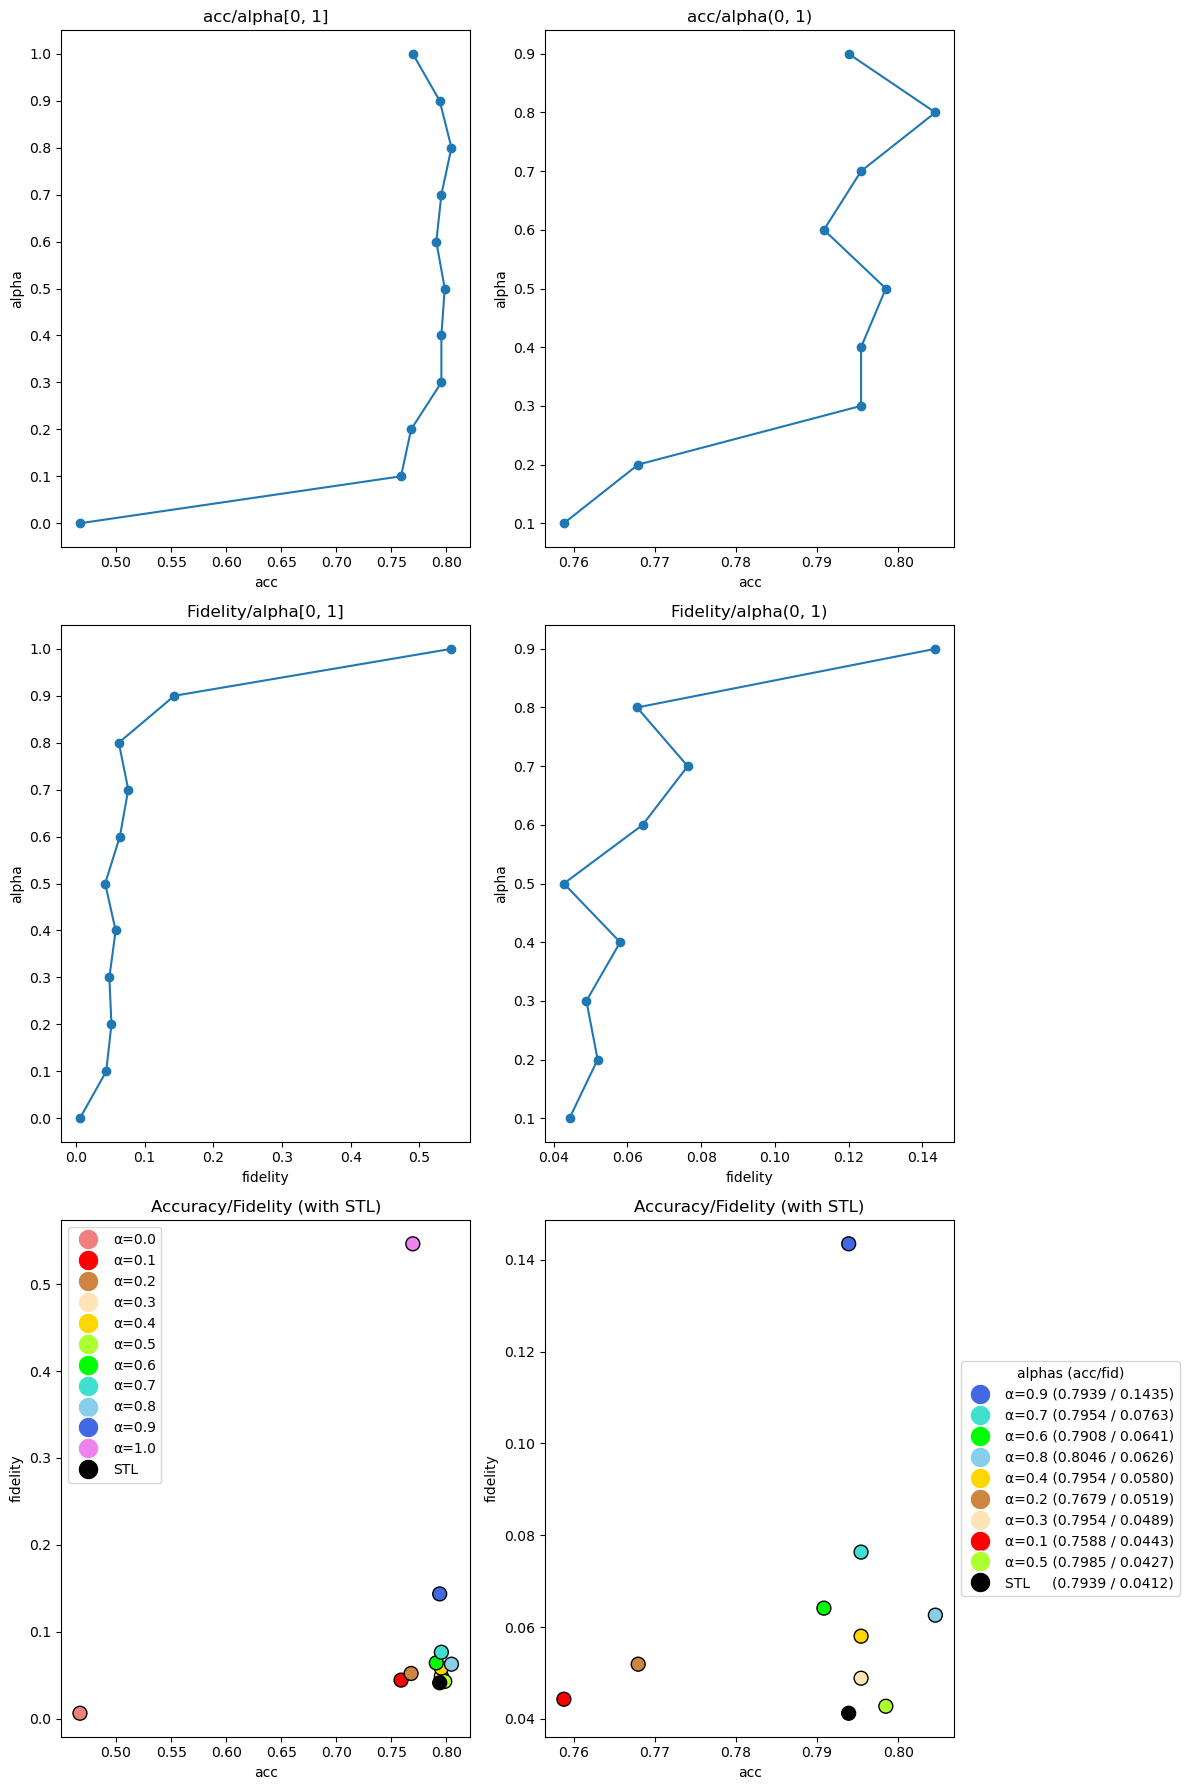

In [122]:
draw_plots_MTL_vs_STL(
    metrics_label='acc',
    metrics_title='Accuracy',
    config=titanic_cfg
)

### Local Explainability Evaluation

Creating Explainer

In [123]:
titanic_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=titanic_X_train_np,
    mode='classification',
    feature_names=titanic_cfg.features.names,
    verbose=False,
    class_names=['not survived', 'survived'],
    categorical_features=titanic_cfg.features.categorical_indices,
    categorical_names=titanic_cfg.features.values_names,
    discretize_continuous=False
)
titanic_explainer

Global Neighborhood Fidelity for STL MLP

In [127]:
# load model
mlp = MLP_cls(input_size=titanic_cfg.input_size, hidden_sizes=MLP_cls.get_hidden_sizes(titanic_cfg.best_parameters, titanic_cfg)).to(titanic_cfg.device)
mlp.load_state_dict(torch.load(titanic_cfg.models.mlp_opt + '0' + titanic_cfg.models.ext))

# prediction function
titanic_predict_lime = partial(predict_cls_for_lime, model=mlp, config=titanic_cfg)

# neighbors dataset
print(titanic_X_test_np.shape)


titanic_cfg.results.stl_gnf = global_neighborhood_fidelity_cls(
    model=mlp,
    neighbors_dataset=titanic_X_test_np,
    explainer=titanic_explainer,
    config=titanic_cfg,
    predict_func_lime=titanic_predict_lime,
    predict_func_model=predict_cls_for_lime
)
titanic_cfg.results.stl_gnf

(131, 7)


tensor(0.3076)

Global Neighborhood Fidelity for MTL

In [128]:
global_neighborhood_fidelity_mtl_cls(
    neighbors_dataset=titanic_X_test_np,
    explainer=titanic_explainer,
    model_params=titanic_cfg.best_parameters,
    config=titanic_cfg
)

Model for alpha: 0.0
Model: Titanic/mtl_alpha_0.0_0.pt, GNF: 0.16106870770454407
Model for alpha: 0.1
Model: Titanic/mtl_alpha_0.1_0.pt, GNF: 0.31450381875038147
Model for alpha: 0.2
Model: Titanic/mtl_alpha_0.2_0.pt, GNF: 0.3015267252922058
Model for alpha: 0.3
Model: Titanic/mtl_alpha_0.3_0.pt, GNF: 0.2977099120616913
Model for alpha: 0.4
Model: Titanic/mtl_alpha_0.4_0.pt, GNF: 0.35954198241233826
Model for alpha: 0.5
Model: Titanic/mtl_alpha_0.5_0.pt, GNF: 0.35267174243927
Model for alpha: 0.6
Model: Titanic/mtl_alpha_0.6_0.pt, GNF: 0.35114502906799316
Model for alpha: 0.7
Model: Titanic/mtl_alpha_0.7_0.pt, GNF: 0.3358778655529022
Model for alpha: 0.8
Model: Titanic/mtl_alpha_0.8_0.pt, GNF: 0.33893129229545593
Model for alpha: 0.9
Model: Titanic/mtl_alpha_0.9_0.pt, GNF: 0.2992366850376129
Model for alpha: 1.0
Model: Titanic/mtl_alpha_1.0_0.pt, GNF: 0.28549620509147644


In [126]:
show_tables_lime("Accuracy", titanic_cfg) 

Metric,Dataset,Linear,STL,MTL a= 0.0,MTL a= 0.1,MTL a= 0.2,MTL a= 0.3,MTL a= 0.4,MTL a= 0.5,MTL a= 0.6,MTL a= 0.7,MTL a= 0.8,MTL a= 0.9,MTL a= 1.0
Accuracy,Titanic,"0,748","0,809","0,534","0,802","0,756","0,771","0,802","0,794","0,809","0,809","0,809","0,809","0,763"
Global Neighborhood Fidelity,Titanic,-,"0,308","0,182","0,314","0,312","0,308","0,362","0,344","0,359","0,329","0,353","0,299","0,279"
